In [326]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import scipy.optimize
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy.interpolate import pchip_interpolate
import numpy as np
import math
from pandas import Series
from lmfit import Model, Parameter, report_fit
import scipy.ndimage
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from numpy import ones,vstack
from numpy.linalg import lstsq

In [2]:
# This returns a list of names (strings) of files that have the .txt extension. 
# You should provide the path
files = glob.glob('../../../CDOM_DATA/BLU22/BC_ABS_BLU22_2226_GB/*.txt')

In [3]:
#first Identify what wavegide was used then uncomment the correct waveguide 
X = .488 # 50 cm lwcc number 3 SN: , Basiclly antything from GOM22SP thats not PW
#X = .0.489 # 50 cm lwcc number 2 SN: , Basiclly antything from GOMFASP thats not PW

In [4]:
#SAMPLE OPENS FILES 
def open_file(name):
    # returns a datafame from a raw file
    # input: filename (string)
    # output: pandas dataframe 
    df = pd.read_csv(name, skiprows=14, sep='\t', names=['wl', 'abs'], )
    return df

In [5]:
#SAMPLE ABS TRANSFORM AND BASLINE CORRECTION 
def abs_base_cor(name):
    # unit conversion
    df['abs'] = df['abs']*(2.303/X)
    # baseline correction
    bcorr = df[(df['wl']>=700) & (df['wl']<=750)]['abs'].mean() # a float
    df['abs'] = df['abs'] - bcorr
    return df

In [6]:
#SAMPLE PCHIPS DATA INTO WHOLE WAVELENTHS 
def Pchip(name):
    #PCHIP 1-D monotonic cubic interpolation.
    #x and y are arrays of values used to approximate some function f, with y = f(x).
    #The interpolant uses monotonic cubic splines to find the value of new points. 
    #PCHIP stands for Piecewise Cubic Hermite Interpolating Polynomial
    x = df['wl']
    y = df['abs']
    #dose the interplation 
    pchip_obj1 = scipy.interpolate.PchipInterpolator(x, y, axis=0, extrapolate=None)
    #pulls the wavelenths data point from the interplation 
    xi = np.arange(189,881,1)
    #pulls the abs values from the wavelenths from the interplation
    yi = pchip_obj1(xi)
    #this turns it back into a dataframe 
    d = {'wl': xi, 'abs': yi}
    df = pd.DataFrame(d)
    return df

PART 1: GRAPHS AND WAVELENGTHS 

we use pchip to process the data to get the wavelenths in whole numbers 

we will save this to a output tabel 

we will also save the baseline correction 

In [7]:
#FINAL FUNTION 
#see above for the breakdown of diff parts 
def GET_CDOM_DATA(name):
    df = pd.read_csv(name, skiprows=14, sep='\t', names=['wl', 'abs'], )
    df['abs'] = df['abs']*(2.303/X)
    #bcorr = df[(df['wl']>=700) & (df['wl']<=701)]['abs'].mean() # a float corection with just 700 nm 
    #bcorr = df[(df['wl']>=700) & (df['wl']<=750)]['abs'].mean() # a float corection with 700 to 750 nm 
    #df['abs'] = df['abs'] - bcorr
    x = df['wl']
    y = df['abs'] 
    pchip_obj1 = scipy.interpolate.PchipInterpolator(x, y, axis=0, extrapolate=None)
    xi = np.arange(189,881,1)
    yi = pchip_obj1(xi)
    d = {'wl': xi, 'abs': yi}
    df = pd.DataFrame(d)
    return df

In [8]:
#TEST FUNCTION 
GET_CDOM_DATA(files[0])

,wl,abs
0,189,0.000000
1,190,0.000000
2,191,0.000000
3,192,-1.465893
4,193,-3.058874
...,...,...
687,876,0.216616
688,877,0.311587
689,878,0.346446
690,879,0.656970


In [9]:
#MAKE IT ALL IN ONE EASY TO USE DATA FRAME 
#this makes a new data frame there all the columns are the scanns and the rows are the wavelths 
frames = []
for f in files:
    df = GET_CDOM_DATA(f) # runs the processing function 
    ID = f.split("/")[5][21:-4] #takes junk out of the file name to make a single ID 
    df = df.rename(columns={'abs': ID}) # renames the abs col to the new id 
    df = df.set_index('wl', drop=True) # makes the wl the new index, aka the rows 
    frames.append(df) # adds the new col from each scan to a part of frames 
df = pd.concat(frames, axis=1, ignore_index=False) # adds all the things in the frame together to make a new df 
df

,222601_Absorbance__0__00,222601_Absorbance__1__01,222602_Absorbance__0__02,222603_Absorbance__0__03,222604_Absorbance__0__04,222605_Absorbance__0__05,222606_Absorbance__0__06,222607_Absorbance__0__07,222607_Absorbance__0__08,222607_Absorbance__1__09,...,222616_Absorbance__2__40,222616_Absorbance__3__41,222616_Absorbance__4__42,222616_Absorbance__5__43,222617_Absorbance__0__44,222617_Absorbance__1__45,222617_Absorbance__2__46,222618_Absorbance__0__47,222618_Absorbance__1__48,222618_Absorbance__2__49
wl,,,,,,,,,,,,,,,,,,,,,
189,0.000000,-0.629550,0.000000,0.000000,-4.074139,-5.726825,-6.655104,0.000000,0.000000,0.000000,...,0.000000,8.314396,2.697058,3.126039,0.604066,0.000000,-3.750870,-2.978326,-2.101016,-3.200604
190,0.000000,-0.629550,0.000000,0.000000,-4.074139,-5.726825,-6.655104,0.000000,0.000000,0.000000,...,0.000000,8.314396,2.697058,3.126039,0.604066,0.000000,-3.750870,-2.978326,-2.101016,-3.200604
191,0.000000,-1.590073,0.000000,0.000000,0.000000,-2.626152,-3.237986,-0.329594,-0.015785,0.000000,...,0.000000,1.316492,3.457386,1.772364,-5.235417,-5.795684,-5.481341,-7.060380,-4.608921,-6.722031
192,-1.465893,-1.974047,0.649543,-5.605313,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.223368,2.801201,1.481845,0.038832,0.089555,-2.723755,1.074593,0.000000,0.000000,0.000000
193,-3.058874,-1.034192,0.385857,0.000000,-0.421353,-0.602811,-0.737553,0.370283,-1.286640,-1.494576,...,0.433319,1.898539,1.452236,2.754899,0.282135,1.101186,-0.614859,0.192907,-1.312218,-0.259390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,0.216616,0.352275,0.165187,1.363944,0.388430,1.046139,1.372585,0.017150,0.210191,0.007038,...,0.422086,0.648095,0.545300,0.628706,0.114163,-0.105751,-0.046998,0.177283,0.085863,0.252717
877,0.311587,-0.078003,0.420645,1.080102,0.547478,0.756692,1.703318,0.177034,0.463064,0.088475,...,0.415060,0.523610,0.392132,0.529303,-0.161306,-0.041337,0.027430,0.061988,-0.039242,0.068704
878,0.346446,-0.132605,0.311914,1.136897,0.319051,1.346101,1.960400,0.361669,0.174915,0.167318,...,0.277432,0.685614,0.387879,0.434012,-0.007072,-0.063349,-0.152620,0.422268,0.100387,0.104077


In [10]:
#HERE WE ARE GOING TO AVERAGE THE SCANNS TO GET A VALUE FOR EACH WAVELENTH
#this filters eveything by all that have the work 'Absorbance' with anything after it 
#and turns it into a new object 
d = df.filter(regex='Absorbance*', axis=1)
#this splits the column names by 
names = d.columns.str.rsplit('_', n=5).str[0]
#this part groups evethign by the sample ID that we have in names then avarages all scanns regardless of how many there are 
df = d.groupby(names, axis=1).mean()
df

,222601,222602,222603,222604,222605,222606,222607,222608,222609,222610,222611,222612,222613,222614,222615,222616,222617,222618
wl,,,,,,,,,,,,,,,,,,
189,-0.314775,0.000000,0.000000,-4.074139,-5.726825,-6.655104,0.000000,0.000000,0.000000,-0.515029,0.000000,0.000000,-0.376440,-0.070868,0.000000,2.356249,-1.048935,-2.759982
190,-0.314775,0.000000,0.000000,-4.074139,-5.726825,-6.655104,0.000000,0.000000,0.000000,-0.515029,0.000000,0.000000,-0.376440,-0.070868,0.000000,2.356249,-1.048935,-2.759982
191,-0.795036,0.000000,0.000000,0.000000,-2.626152,-3.237986,-0.086345,0.000000,0.000000,-2.586899,-1.743243,-4.171799,-1.272784,-0.422596,0.015549,1.091040,-5.504147,-6.130444
192,-1.719970,0.649543,-5.605313,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.443731,0.000000,0.662637,0.094438,-0.360383,0.612337,-0.519869,0.000000
193,-2.046533,0.385857,0.000000,-0.421353,-0.602811,-0.737553,-0.994587,-2.666456,-3.422510,2.672758,0.568182,0.966235,-0.916058,-0.018739,0.081182,1.181955,0.256154,-0.459567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,0.284446,0.165187,1.363944,0.388430,1.046139,1.372585,0.116998,0.493607,0.956460,0.381992,0.326046,0.356622,0.283348,0.138615,0.241665,0.474531,-0.012862,0.171954
877,0.116792,0.420645,1.080102,0.547478,0.756692,1.703318,0.225502,0.568640,0.951268,0.272092,0.328950,0.525677,0.148345,0.204604,0.313365,0.473657,-0.058404,0.030483
878,0.106921,0.311914,1.136897,0.319051,1.346101,1.960400,0.251953,0.609822,0.928801,0.357045,0.487260,0.784820,0.124628,0.230104,0.203997,0.440142,-0.074347,0.208911


In [11]:
#HERE WE DO THE BASLINE CORRECTION AND SAVE THE CORECTION AS 'bcorr'
bcorr = df[486:537].mean(axis=0) # 486:537 is 675 to 725 nm and this line takes the average 
df = df[:] - df[486:537].mean(axis=0) # here we correct the data by that average 
df

,222601,222602,222603,222604,222605,222606,222607,222608,222609,222610,222611,222612,222613,222614,222615,222616,222617,222618
wl,,,,,,,,,,,,,,,,,,
189,-0.271284,-0.004027,-0.067666,-4.193328,-5.761259,-6.679587,0.005348,0.017448,-0.030766,-0.590572,-0.053813,-0.090075,-0.399650,-0.059994,0.037003,2.326328,-1.032927,-2.770808
190,-0.271284,-0.004027,-0.067666,-4.193328,-5.761259,-6.679587,0.005348,0.017448,-0.030766,-0.590572,-0.053813,-0.090075,-0.399650,-0.059994,0.037003,2.326328,-1.032927,-2.770808
191,-0.751545,-0.004027,-0.067666,-0.119189,-2.660585,-3.262469,-0.080996,0.017448,-0.030766,-2.662443,-1.797057,-4.261874,-1.295994,-0.411723,0.052552,1.061119,-5.488140,-6.141271
192,-1.676479,0.645516,-5.672980,-0.119189,-0.034434,-0.024483,0.005348,0.017448,-0.030766,-0.075544,1.389918,-0.090075,0.639427,0.105312,-0.323381,0.582416,-0.503862,-0.010827
193,-2.003042,0.381830,-0.067666,-0.540542,-0.637245,-0.762036,-0.989239,-2.649008,-3.453275,2.597215,0.514368,0.876160,-0.939268,-0.007865,0.118185,1.152033,0.272161,-0.470394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,0.327937,0.161160,1.296278,0.269241,1.011706,1.348101,0.122347,0.511054,0.925695,0.306449,0.272233,0.266547,0.260138,0.149488,0.278667,0.444609,0.003145,0.161128
877,0.160283,0.416618,1.012435,0.428289,0.722259,1.678835,0.230851,0.586088,0.920503,0.196548,0.275137,0.435602,0.125135,0.215478,0.350368,0.443736,-0.042397,0.019657
878,0.150412,0.307887,1.069230,0.199862,1.311667,1.935917,0.257302,0.627270,0.898035,0.281501,0.433446,0.694745,0.101418,0.240977,0.240999,0.410221,-0.058340,0.198084


In [12]:
#HERE WE MAKE A COPY OF THE DATA THAT IS VERTICAL SO JB LIKES IT
Abs_data = df.transpose(copy=False)
Abs_data['bcorr'] = bcorr
Abs_data

#save it as a CSV to the propor location with the correct file name
#Abs_data.to_csv('../outputs/BC_ABS_BLU22_2226_GB_Pchip_wavelenths.csv')

wl,189,190,191,192,193,194,195,196,197,198,...,872,873,874,875,876,877,878,879,880,bcorr
222601,-0.271284,-0.271284,-0.751545,-1.676479,-2.003042,-1.804961,-0.392471,-1.536731,-1.312176,0.787725,...,0.248465,0.434799,0.383241,0.198125,0.327937,0.160283,0.150412,0.531772,0.320325,-0.043491
222602,-0.004027,-0.004027,-0.004027,0.645516,0.381830,-0.004027,-0.004027,-0.004027,-2.693518,0.535853,...,0.175210,0.449884,0.287298,0.205074,0.161160,0.416618,0.307887,0.318366,0.255806,0.004027
222603,-0.067666,-0.067666,-0.067666,-5.672980,-0.067666,-0.067666,-0.067666,-0.067666,-3.867817,1.615317,...,0.879988,0.918683,0.809401,0.485046,1.296278,1.012435,1.069230,1.038550,0.957966,0.067666
222604,-4.193328,-4.193328,-0.119189,-0.119189,-0.540542,-0.119189,-5.954247,-1.990208,0.047843,0.630991,...,0.210155,0.115889,0.322704,0.495794,0.269241,0.428289,0.199862,0.310536,0.807662,0.119189
222605,-5.761259,-5.761259,-2.660585,-0.034434,-0.637245,-0.034434,-7.239152,-3.739897,-0.316301,1.582266,...,0.818652,0.491738,0.726033,1.566024,1.011706,0.722259,1.311667,0.990021,1.108489,0.034434
222606,-6.679587,-6.679587,-3.262469,-0.024483,-0.762036,-0.024483,-8.481622,-4.997903,-0.403270,2.024909,...,1.217073,1.366978,1.636285,1.559750,1.348101,1.678835,1.935917,1.503808,2.396909,0.024483
222607,0.005348,0.005348,-0.080996,0.005348,-0.989239,0.316292,0.484874,0.260564,2.310115,0.665816,...,0.085337,0.058632,0.277524,0.156033,0.122347,0.230851,0.257302,0.339518,0.048997,-0.005348
222608,0.017448,0.017448,0.017448,0.017448,-2.649008,-1.456320,0.017448,-1.047441,0.017448,0.962564,...,0.400327,0.507515,0.469403,0.400564,0.511054,0.586088,0.627270,0.449710,0.372011,-0.017448
222609,-0.030766,-0.030766,-0.030766,-0.030766,-3.453275,-2.257942,-0.030766,-1.532259,-0.030766,1.813900,...,0.697051,0.789001,0.922485,0.917399,0.925695,0.920503,0.898035,1.035176,0.989198,0.030766
222610,-0.590572,-0.590572,-2.662443,-0.075544,2.597215,1.624276,0.013642,-1.467656,0.918050,0.276844,...,0.229794,0.283156,0.261226,0.262640,0.306449,0.196548,0.281501,0.022581,0.269319,0.075544


Text(0.5, 1.0, 'BC_ABS_BLU22_2226_GB')

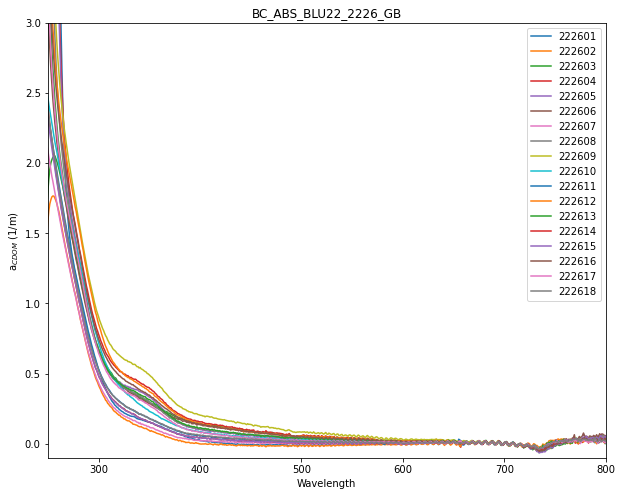

In [13]:
#HERE, WE MAKE A QUICK AND DIRTY GRAPH OF THE DATA TO SAVE AND CHECK WORK 
fig, ax = plt.subplots(figsize=(10,8))
df.plot(label='', ax=ax)
ax.set_ylim(-.1,3)
ax.set_xlim(250,800)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.set_title("BC_ABS_BLU22_2226_GB")

#plt.savefig("../outputs/BC_ABS_BLU22_2226_GB_plot.png")

PART 2: REGRESSIONS

I need an output table for each sampling event with the sample number

we will get this with 2 regression methods 

there are two ways we are going to calculate the spectral slopes 
1. Single exponential (SEM) where: $A(g)=Ae^{slope}$
2. Hyperbolic (HM) where: $A(g)=A(\frac{wl}{532})^{slope}$

corresponding parameters = abs 254, abs 280, abs 320, abs 412, abs 444 

corresponding parameters = the spectral slope of 275 to 295, the spectral slope of 350 to 400, the spectral slope of 275 to 700

corresponding parameters = spectral ratio of spectral slope of 275 to 295 and the spectral slope of 350 to 400

corresponding parameters = baseline correction we used, so the b term 


In [455]:
#OPEN OUR FILES AND MAKE ABSORBANCE TO ABSORPTION
def open_file_abs_base_cor(name):
    df = pd.read_csv(name, skiprows=14, sep='\t', names=['wl', 'abs'], )
    df['abs'] = df['abs']*(2.303/X)
    return df

In [456]:
#MAKE IT ALL IN ONE EASY TO USE DATA FRAME 
#this makes a new data frame there all the columns are the scanns and the rows are the wavelths 
frames = []
for f in files:
    df = open_file_abs_base_cor(f) # runs the processing function 
    ID = f.split("/")[5][21:-4] #takes junk out of the file name to make a single ID 
    df = df.rename(columns={'abs': ID}) # renames the abs col to the new id 
    df = df.set_index('wl', drop=True) # makes the wl the new index, aka the rows 
    frames.append(df) # adds the new col from each scan to a part of frames 
df = pd.concat(frames, axis=1, ignore_index=False) # adds all the things in the frame together to make a new df 

#HERE WE ARE GOING TO AVERAGE THE SCANNS TO GET A VALUE FOR EACH WAVELENTH 
d = df.filter(regex='Absorbance*', axis=1)
#this splits the column names by 
names = d.columns.str.rsplit('_', n=5).str[0]
#this part groups evethign by the sample ID that we have in names then avarages all scanns regardless of how many there are 
df = df.groupby(names, axis=1).mean()
df

,222601,222602,222603,222604,222605,222606,222607,222608,222609,222610,222611,222612,222613,222614,222615,222616,222617,222618
wl,,,,,,,,,,,,,,,,,,
189.2794,-0.314775,0.000000,0.000000,-4.074139,-5.726825,-6.655104,0.000000,0.000000,0.000000,-0.515029,0.000000,0.000000,-0.376440,-0.070868,0.000000,2.356249,-1.048935,-2.759982
189.6618,-0.314775,0.000000,0.000000,-4.074139,-5.726825,-6.655104,0.000000,0.000000,0.000000,-0.515029,0.000000,0.000000,-0.376440,-0.070868,0.000000,2.356249,-1.048935,-2.759982
190.0441,-0.314775,0.000000,0.000000,-4.074139,-5.726825,-6.655104,0.000000,0.000000,0.000000,-0.515029,0.000000,0.000000,-0.376440,-0.070868,0.000000,2.356249,-1.048935,-2.759982
190.4264,-2.412959,0.000000,0.000000,0.000000,0.000000,0.000000,-1.994124,0.000000,0.000000,0.524625,0.000000,0.792521,0.000000,1.284819,-0.292752,0.000000,-1.725520,0.000000
190.8087,-0.865277,0.000000,0.000000,0.000000,-5.260562,-6.486154,-0.172961,0.000000,0.000000,-2.281921,-1.262560,-4.727128,0.000000,0.741553,0.031147,1.357260,-1.442207,-1.849322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880.5978,0.383440,-0.124117,1.067497,0.315247,0.583301,1.567267,0.141696,0.367631,1.064036,0.305336,0.320753,0.449431,0.423003,0.326652,0.318708,0.536737,0.009439,0.344978
880.8884,0.184051,0.271358,1.049564,0.617751,1.164714,1.752734,-0.145471,0.151331,0.700968,0.456353,0.248548,0.588020,0.296370,0.341203,0.382260,0.632774,0.333966,0.289605
881.1790,0.260503,0.249649,1.233143,0.506377,0.956123,2.118005,0.150309,0.496938,1.200738,0.549794,0.459971,0.616178,0.371878,0.278358,0.344034,0.555850,-0.155578,0.143623


In [457]:
#EXPONENTAL REGRESSION A(g)=Ae^slope
def exp_equation(x, a, s, b):
    return a * np.exp(-s * x) + b

In [458]:
#HERE WE PULL THE X AND Y DATA FOR THE REGRESSION AND GET SOME INNITAL GUESS VALULES
#FOR JUST ONE SAMPLE 

df['wl'] = df.index

#get the x and y values for all the slope intervals we want 
ydata_s700 = df[(df['wl']>=275) & (df['wl']<=700)][names[0]]
xdata_s700 = df[(df['wl']>=275) & (df['wl']<=700)]['wl']
ydata_s700 = np.asarray(ydata_s700, dtype=float).ravel()
xdata_s700 = np.asarray(xdata_s700, dtype=float).ravel()
ydata_s295 = df[(df['wl']>=275) & (df['wl']<=295)][names[0]]
xdata_s295 = df[(df['wl']>=275) & (df['wl']<=295)]['wl']
ydata_s295 = np.asarray(ydata_s295, dtype=float).ravel()
xdata_s295 = np.asarray(xdata_s295, dtype=float).ravel()
ydata_s350 = df[(df['wl']>=350) & (df['wl']<=400)][names[0]]
xdata_s350 = df[(df['wl']>=350) & (df['wl']<=400)]['wl']
ydata_s350 = np.asarray(ydata_s350, dtype=float).ravel()
xdata_s350 = np.asarray(xdata_s350, dtype=float).ravel()

#set some innital guesses to the curve fit 
pams_700 = (15, .001, 0)
pams_295 = (10, .001, 0)
pams_350 = (10, .001, 0)

#set the max evaluations
maxfev = 99999999

for spectral slope 275 to 700
abs 254 = 2.808497649838325
R² = 0.9924311972786258
absorption coefficient = 14748.808579498871
offset = -0.042128360444240384
Spectral Slope = 0.03393404349739338

for spectral slope 275 to 295
R² = 0.9997640856916626
absorption coefficient = 56.31813143965838
offset = -2.278768484623976
Spectral Slope = 0.010068051270485101

for spectral slope 350 to 400
R² = 0.9965242426223554
absorption coefficient = 11.602046616843033
offset = -0.23065762311445615
Spectral Slope = 0.010055156225525812



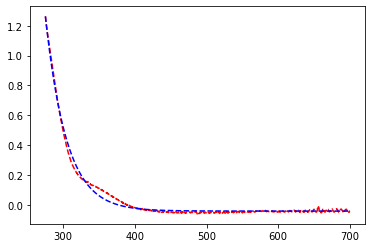

In [459]:
#HERE WE DO THE EXPO REGRESSION AND PRINT THE VARS AS A TEST 
#FOR JUST ONE SAMPLE 

params, cv = curve_fit(exp_equation, xdata_s700, ydata_s700, p0=pams_700, maxfev = maxfev)
a, s, b = params

squaredDiffs = np.square(ydata_s700 - exp_equation(xdata_s700, a, s, b))
squaredDiffsFromMean = np.square(ydata_s700 - np.mean(ydata_s700))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
abs_254 = exp_equation(252, a, s, b)
print("for spectral slope 275 to 700")
print(f"abs 254 = {abs_254}")
print(f"R² = {rSquared}")
print(f"absorption coefficient = {a}")
print(f"offset = {b}")
print(f"Spectral Slope = {s}")
print(f"")

#uncomment this to look at the fit
plt.plot(xdata_s700, ydata_s700, '--', color='red', label="data")
plt.plot(xdata_s700, exp_equation(xdata_s700, a, s, b), '--', color='blue', label="fitted")

params, cv = curve_fit(exp_equation, xdata_s295, ydata_s295, p0=pams_295, maxfev = maxfev)
a, s, b = params

squaredDiffs = np.square(ydata_s295 - exp_equation(xdata_s295, a, s, b))
squaredDiffsFromMean = np.square(ydata_s295 - np.mean(ydata_s295))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print("for spectral slope 275 to 295")
print(f"R² = {rSquared}")
print(f"absorption coefficient = {a}")
print(f"offset = {b}")
print(f"Spectral Slope = {s}")
print(f"")

#uncomment this to look at the fit
#plt.plot(xdata_s295, ydata_s295, '--', color='red', label="data")
#plt.plot(xdata_s295, exp_equation(xdata_s295, a, s, b), '--', color='blue', label="fitted")

params, cv = curve_fit(exp_equation, xdata_s350, ydata_s350, p0=pams_350, maxfev = maxfev)
a, s, b = params

squaredDiffs = np.square(ydata_s350 - exp_equation(xdata_s350, a, s, b))
squaredDiffsFromMean = np.square(ydata_s350 - np.mean(ydata_s350))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print("for spectral slope 350 to 400")
print(f"R² = {rSquared}")
print(f"absorption coefficient = {a}")
print(f"offset = {b}")
print(f"Spectral Slope = {s}")
print(f"")

#uncomment this to look at the fit
#plt.plot(xdata_s350, ydata_s350, '--', color='red', label="data")
#plt.plot(xdata_s350, exp_equation(xdata_s350, a, s, b), '--', color='blue', label="fitted")

In [19]:
#HERE DO THE WHOLE EXPO AS A LOOP FOR ALL SAMPLES 
Frames = []
maxfev = 10000000
for (columnName, columnData) in df.iteritems():
    col = columnName
    #get the x and y values for all the slope intervals we want 
    ydata_s700 = df[(df['wl']>=275) & (df['wl']<=700)][col]
    xdata_s700 = df[(df['wl']>=275) & (df['wl']<=700)]['wl']
    ydata_s700 = np.asarray(ydata_s700, dtype=float).ravel()
    xdata_s700 = np.asarray(xdata_s700, dtype=float).ravel()
    ydata_s295 = df[(df['wl']>=275) & (df['wl']<=295)][col]
    xdata_s295 = df[(df['wl']>=275) & (df['wl']<=295)]['wl']
    ydata_s295 = np.asarray(ydata_s295, dtype=float).ravel()
    xdata_s295 = np.asarray(xdata_s295, dtype=float).ravel()
    ydata_s350 = df[(df['wl']>=350) & (df['wl']<=400)][col]
    xdata_s350 = df[(df['wl']>=350) & (df['wl']<=400)]['wl']
    ydata_s350 = np.asarray(ydata_s350, dtype=float).ravel()
    xdata_s350 = np.asarray(xdata_s350, dtype=float).ravel()
    
    #set some innital guesses to the curve fit 
    pams_700 = (15, .001, 0)
    pams_295 = (10, .001, 0)
    pams_350 = (10, .001, 0)
    
    #regression exp_equation 275 to 700
    params, cv = curve_fit(exp_equation, xdata_s700, ydata_s700, p0=pams_700, maxfev=maxfev)
    a, s, b = params
    
    #get the valuse for exp_equation 275 to 700 and calcuate rSquared
    squaredDiffs = np.square(ydata_s700 - exp_equation(xdata_s700, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s700 - np.mean(ydata_s700))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_275_700 = rSquared
    ss_275_700 = s
    
    #get the waveleths we need
    abs_254 = exp_equation(252, a, s, b)
    abs_280 = exp_equation(280, a, s, b)
    abs_320 = exp_equation(320, a, s, b)
    abs_350 = exp_equation(350, a, s, b)
    abs_412 = exp_equation(412, a, s, b)
    abs_440 = exp_equation(440, a, s, b)
    
    #regression exp_equation 275 to 295
    params, cv = curve_fit(exp_equation, xdata_s295, ydata_s295, p0=pams_295, maxfev=maxfev)
    a, s, b = params
    
    #get the valuse for exp_equation 270 to 295 and calcuate rSquared
    squaredDiffs = np.square(ydata_s295 - exp_equation(xdata_s295, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s295 - np.mean(ydata_s295))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_275_295 = rSquared
    ss_275_295 = s
    
    #regression exp_equation 350 to 400
    params, cv = curve_fit(exp_equation, xdata_s350, ydata_s350, p0=pams_350, maxfev=maxfev)
    a, s, b = params
    
    #get the valuse for exp_equation 350 to 400 and calcuate rSquared
    squaredDiffs = np.square(ydata_s350 - exp_equation(xdata_s350, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s350 - np.mean(ydata_s350))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_350_400 = rSquared
    ss_350_400 = s 
    
    #get the spectral ratio 
    sr = ss_275_295 / ss_350_400
    
    dict = {'sample':[columnName],
        'ss_275_700_SEM':[ss_275_700],
        'ss_275_295_SEM':[ss_275_295],
        'ss_350_400_SEM':[ss_350_400],
        'R2_275_700':[R2_275_700],
        'R2_275_295':[R2_275_295],
        'R2_350_400':[R2_350_400],
        'SR_SEM':[sr],
        'abs_254_SEM':[abs_254], 
        'abs_280_SEM':[abs_280],
        'abs_320_SEM':[abs_320], 
        'abs_350_SEM':[abs_350],
        'abs_412_SEM':[abs_412], 
        'abs_440_SEM':[abs_440]}
    ss_outs = pd.DataFrame(dict)
    ss_outs = ss_outs.set_index('sample', drop=True)
    Frames.append(ss_outs)

ss_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs = ss_outs.drop('wl')
ss_outs

,ss_275_700_SEM,ss_275_295_SEM,ss_350_400_SEM,R2_275_700,R2_275_295,R2_350_400,SR_SEM,abs_254_SEM,abs_280_SEM,abs_320_SEM,abs_350_SEM,abs_412_SEM,abs_440_SEM
sample,,,,,,,,,,,,,
222601,0.033934,0.010068,0.010055,0.992431,0.999764,0.996524,1.001282,2.808498,1.060157,0.241532,0.060361,-0.029627,-0.037294
222602,0.036977,0.018067,0.028121,0.995393,0.999540,0.989926,0.642471,2.658364,0.943303,0.214104,0.069890,0.006095,0.001472
222603,0.022858,0.021325,0.022604,0.983594,0.999652,0.995448,0.943440,2.249979,1.236006,0.558299,0.333338,0.160354,0.134191
222604,0.021042,0.013774,0.028720,0.983188,0.999666,0.995362,0.479593,2.483500,1.446532,0.711282,0.450615,0.234757,0.198982
222605,0.024116,0.012150,0.032124,0.981284,0.999671,0.994339,0.378223,2.467542,1.284629,0.525606,0.284907,0.109005,0.084045
222606,0.023556,0.018609,0.026317,0.983684,0.999763,0.995793,0.707085,2.229893,1.182376,0.497933,0.276426,0.110850,0.086678
222607,0.035048,0.019662,0.030078,0.995571,0.999702,0.993584,0.653714,2.478950,0.930268,0.230343,0.081684,0.010926,0.005244
222608,0.025308,0.014741,0.029815,0.985741,0.999744,0.995834,0.494412,2.467695,1.221641,0.452369,0.218784,0.056073,0.034348
222609,0.019013,0.015860,0.028075,0.982875,0.999738,0.995796,0.564923,2.508197,1.504575,0.744197,0.454098,0.192895,0.144984


In [20]:
#HERE WE TEST TO MAKE SURE THE R SQAURED IS GOOD 
#this will let us know if something is wrong and where 

ss_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs = ss_outs.drop('wl')

R_level = .95 #set x to the r2 value you want to test

min_1 = ss_outs['R2_275_700'].min()
min_2 = ss_outs['R2_275_295'].min()
min_3 = ss_outs['R2_350_400'].min()

if min_1 < R_level: 
    print("!!! WARNING !!! 275_700 has a bad R2 !!!")
if min_2 < R_level:
    print("!!! WARNING !!! 275_295 has a bad R2 !!!")
if min_3 < R_level:
    print("!!! WARNING !!! 350_400 has a bad R2 !!!")
else: 
    print("THE FITS ARE GOOD, YAY!")
    
ss_outs.loc[ss_outs.R2_275_700 < R_level, 'ss_275_700_SEM'] = np.nan
ss_outs.loc[ss_outs.R2_275_295 < R_level, 'ss_275_295_SEM'] = np.nan
ss_outs.loc[ss_outs.R2_350_400 < R_level, 'ss_350_400_SEM'] = np.nan
    
#HERE WE SAME THE SLOPE VALUES 
ss_275_700_SEM = ss_outs['ss_275_700_SEM']
ss_275_295_SEM = ss_outs['ss_275_295_SEM']
ss_350_400_SEM = ss_outs['ss_350_400_SEM']
abs_254_SEM = ss_outs['abs_254_SEM']
abs_280_SEM = ss_outs['abs_280_SEM']
abs_320_SEM = ss_outs['abs_320_SEM']
abs_412_SEM = ss_outs['abs_412_SEM']
abs_440_SEM = ss_outs['abs_440_SEM']
SR_SEM = ss_outs['SR_SEM']

THE FITS ARE GOOD, YAY!


In [21]:
#HYPERBOLIC REGRESSION A(g)=A(wl/532)^slope
def hyp_equation(x, a, s, b):
    return a * ((x/532)**-s) + b

In [22]:
#HERE WE PULL THE X AND Y DATA FOR THE REGRESSION AND GET SOME INNITAL GUESS VALULES
#FOR JUST ONE SAMPLE 

df['wl'] = df.index

#get the x and y values for all the slope intervals we want 
ydata_s700 = df[(df['wl']>=275) & (df['wl']<=700)][names[0]]
xdata_s700 = df[(df['wl']>=275) & (df['wl']<=700)]['wl']
ydata_s700 = np.asarray(ydata_s700, dtype=float).ravel()
xdata_s700 = np.asarray(xdata_s700, dtype=float).ravel()
ydata_s295 = df[(df['wl']>=275) & (df['wl']<=295)][names[0]]
xdata_s295 = df[(df['wl']>=275) & (df['wl']<=295)]['wl']
ydata_s295 = np.asarray(ydata_s295, dtype=float).ravel()
xdata_s295 = np.asarray(xdata_s295, dtype=float).ravel()
ydata_s350 = df[(df['wl']>=350) & (df['wl']<=400)][names[0]]
xdata_s350 = df[(df['wl']>=350) & (df['wl']<=400)]['wl']
ydata_s350 = np.asarray(ydata_s350, dtype=float).ravel()
xdata_s350 = np.asarray(xdata_s350, dtype=float).ravel()

#set some innital guesses to the curve fit 
pams_700 = (15, .001, 0)
pams_295 = (10, .001, 0)
pams_350 = (10, .001, 0)

#set the max evaluations
maxfev = 99999999

for spectral slope 275 to 700
R² = 0.9941911457032413
absorption coefficient = 0.0016030429958075007
offset = -0.045694057097983166
Spectral Slope = 10.196137170157128

for spectral slope 275 to 700
R² = 0.999763635888518
absorption coefficient = 1.5332042157550763
offset = -3.9961586574300605
Spectral Slope = 1.8656035146505539

for spectral slope 275 to 700
R² = 0.9964637792360636
absorption coefficient = 0.1415291090063878
offset = -0.3314851759691716
Spectral Slope = 2.73336380585253



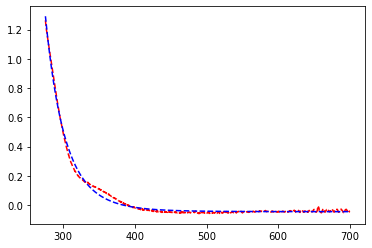

In [23]:
#HERE WE DO THE HYPER REGRESSION AND PRINT THE VARS AS A TEST 
#FOR JUST ONE SAMPLE 
#set some innital guesses to the curve fit 
pams_700 = (.001, 11, 0)
pams_295 = (1, 0, 1)
pams_350 = (1, 1, 1)

maxfev = 10000000

params, cv = curve_fit(hyp_equation, xdata_s700, ydata_s700, p0=pams_700, maxfev = maxfev)
a, s, b = params

squaredDiffs = np.square(ydata_s700 - hyp_equation(xdata_s700, a, s, b))
squaredDiffsFromMean = np.square(ydata_s700 - np.mean(ydata_s700))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print("for spectral slope 275 to 700")
print(f"R² = {rSquared}")
print(f"absorption coefficient = {a}")
print(f"offset = {b}")
print(f"Spectral Slope = {s}")
print(f"")

plt.plot(xdata_s700, ydata_s700, '--', color='red', label="data")
plt.plot(xdata_s700, hyp_equation(xdata_s700, a, s, b), '--', color='blue', label="fitted")

params, cv = curve_fit(hyp_equation, xdata_s295, ydata_s295, p0=pams_295, maxfev = maxfev)
a, s, b = params

squaredDiffs = np.square(ydata_s295 - hyp_equation(xdata_s295, a, s, b))
squaredDiffsFromMean = np.square(ydata_s295 - np.mean(ydata_s295))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print("for spectral slope 275 to 700")
print(f"R² = {rSquared}")
print(f"absorption coefficient = {a}")
print(f"offset = {b}")
print(f"Spectral Slope = {s}")
print(f"")

#plt.plot(xdata_s295, ydata_s295, '--', color='red', label="data")
#plt.plot(xdata_s295, hyp_equation(xdata_s295, a, s, b), '--', color='blue', label="fitted")

params, cv = curve_fit(hyp_equation, xdata_s350, ydata_s350, p0=pams_350,  maxfev = maxfev)
a, s, b = params

squaredDiffs = np.square(ydata_s350 - hyp_equation(xdata_s350, a, s, b))
squaredDiffsFromMean = np.square(ydata_s350 - np.mean(ydata_s350))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print("for spectral slope 275 to 700")
print(f"R² = {rSquared}")
print(f"absorption coefficient = {a}")
print(f"offset = {b}")
print(f"Spectral Slope = {s}")
print(f"")

#plt.plot(xdata_s350, ydata_s350, '--', color='red', label="data")
#plt.plot(xdata_s350, hyp_equation(xdata_s350, a, s, b), '--', color='blue', label="fitted")

In [24]:
Frames = []
maxfev = 10000000
for (columnName, columnData) in df.iteritems():
    col = columnName
    #get the x and y values for all the slope intervals we want 
    #get the x and y values for all the slope intervals we want 
    ydata_s700 = df[(df['wl']>=275) & (df['wl']<=700)][col]
    xdata_s700 = df[(df['wl']>=275) & (df['wl']<=700)]['wl']
    ydata_s700 = np.asarray(ydata_s700, dtype=float).ravel()
    xdata_s700 = np.asarray(xdata_s700, dtype=float).ravel()
    ydata_s295 = df[(df['wl']>=275) & (df['wl']<=295)][col]
    xdata_s295 = df[(df['wl']>=275) & (df['wl']<=295)]['wl']
    ydata_s295 = np.asarray(ydata_s295, dtype=float).ravel()
    xdata_s295 = np.asarray(xdata_s295, dtype=float).ravel()
    ydata_s350 = df[(df['wl']>=350) & (df['wl']<=400)][col]
    xdata_s350 = df[(df['wl']>=350) & (df['wl']<=400)]['wl']
    ydata_s350 = np.asarray(ydata_s350, dtype=float).ravel()
    xdata_s350 = np.asarray(xdata_s350, dtype=float).ravel()
    
    #set some innital guesses to the curve fit 
    pams_700 = (.001, 11, 0)
    pams_295 = (1, 0, 1)
    pams_350 = (1, 1, 1)
    
    maxfev = 1000000
    
    #regression exp_equation 275 to 700
    params, cv = curve_fit(hyp_equation, xdata_s700, ydata_s700, p0=pams_700, maxfev=maxfev)
    a, s, b = params
    
    #print out for exp_equation 275 to 700 and calcuate rSquared
    squaredDiffs = np.square(ydata_s700 - hyp_equation(xdata_s700, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s700 - np.mean(ydata_s700))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_275_700 = rSquared
    ss_275_700 = s
    
    #get the waveleths we need
    abs_254 = hyp_equation(252, a, s, b)
    abs_280 = hyp_equation(280, a, s, b)
    abs_320 = hyp_equation(320, a, s, b)
    abs_350 = hyp_equation(350, a, s, b)
    abs_412 = hyp_equation(412, a, s, b)
    abs_440 = hyp_equation(440, a, s, b)
    
    #regression exp_equation 275 to 295
    params, cv = curve_fit(hyp_equation, xdata_s295, ydata_s295, p0=pams_295, maxfev=maxfev)
    a, s, b = params
    
    #print out for exp_equation 270 to 295 and calcuate rSquared
    squaredDiffs = np.square(ydata_s295 - hyp_equation(xdata_s295, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s295 - np.mean(ydata_s295))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_275_295 = rSquared
    ss_275_295 = s
    
    #regression exp_equation 350 to 400
    params, cv = curve_fit(hyp_equation, xdata_s350, ydata_s350, p0=pams_350, maxfev=maxfev)
    a, s, b = params
    
    #print out for exp_equation 350 to 400 and calcuate rSquared
    squaredDiffs = np.square(ydata_s350 - hyp_equation(xdata_s350, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s350 - np.mean(ydata_s350))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_350_400 = rSquared
    ss_350_400 = s 
    
    #get the spectral ratio 
    sr = ss_275_295 / ss_350_400
    
    dict = {'sample':[columnName],
        'ss_275_700_HM':[ss_275_700],
        'ss_275_295_HM':[ss_275_295],
        'ss_350_400_HM':[ss_350_400],
        'R2_275_700':[R2_275_700],
        'R2_275_295':[R2_275_295],
        'R2_350_400':[R2_350_400],
        'SR_HM':[sr],
        'abs_254_HM':[abs_254], 
        'abs_280_HM':[abs_280],
        'abs_320_HM':[abs_320], 
        'abs_350_HM':[abs_350],
        'abs_412_HM':[abs_412], 
        'abs_440_HM':[abs_440]}
    ss_outs = pd.DataFrame(dict)
    ss_outs = ss_outs.set_index('sample', drop=True)
    Frames.append(ss_outs)

ss_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs = ss_outs.drop('wl')

In [25]:
#HERE WE TEST TO MAKE SURE THE R SQAURED IS GOOD 
#this will let us know if something is wrong and where 

ss_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs = ss_outs.drop('wl')

R_level = .95 #set x to the r2 value you want to test

min_1 = ss_outs['R2_275_700'].min()
min_2 = ss_outs['R2_275_295'].min()
min_3 = ss_outs['R2_350_400'].min()

if min_1 < R_level: 
    print("!!! WARNING !!! 275_700 has a bad R2 !!!")
if min_2 < R_level:
    print("!!! WARNING !!! 275_295 has a bad R2 !!!")
if min_3 < R_level:
    print("!!! WARNING !!! 350_400 has a bad R2 !!!")
else: 
    print("THE FITS ARE GOOD, YAY!")

ss_outs.loc[ss_outs.R2_275_700 < R_level, 'ss_275_700_HM'] = np.nan
ss_outs.loc[ss_outs.R2_275_295 < R_level, 'ss_275_295_HM'] = np.nan
ss_outs.loc[ss_outs.R2_350_400 < R_level, 'ss_350_400_HM'] = np.nan
    
    
#HERE WE SAME THE SLOPE VALUES 
ss_275_700_HM = ss_outs['ss_275_700_HM']
ss_275_295_HM = ss_outs['ss_275_295_HM']
ss_350_400_HM = ss_outs['ss_350_400_HM']
abs_254_HM = ss_outs['abs_254_HM']
abs_280_HM = ss_outs['abs_280_HM']
abs_320_HM = ss_outs['abs_320_HM']
abs_412_HM = ss_outs['abs_412_HM']
abs_440_HM = ss_outs['abs_440_HM']
SR_HM = ss_outs['SR_HM']

THE FITS ARE GOOD, YAY!


In [31]:
#NOW WE SAVE ALL THE VALUSE WE WANTED TO A TABEL 
outputs = pd.concat([ss_275_700_SEM, ss_275_295_SEM, ss_350_400_SEM,
                    ss_275_700_HM, ss_275_295_HM, ss_350_400_HM,
                    abs_254_SEM, abs_280_SEM, abs_320_SEM, abs_412_SEM, abs_440_SEM,
                    abs_254_HM, abs_280_HM, abs_320_HM, abs_412_HM, abs_440_HM,
                    SR_SEM, SR_HM], axis=1)
#outputs = outputs.rename(columns={0: 'baseline_correction', 1: 'abs_254',
#                                  2: 'abs_280', 3: 'abs_320', 4: 'abs_412', 5: 'abs_444'})

outputs 
#SAVE IT 
#outputs.to_csv('../outputs/BC_ABS_BLU22_2226_GB_outputs.csv')

,ss_275_700_SEM,ss_275_295_SEM,ss_350_400_SEM,ss_275_700_HM,ss_275_295_HM,ss_350_400_HM,abs_254_SEM,abs_280_SEM,abs_320_SEM,abs_412_SEM,abs_440_SEM,abs_254_HM,abs_280_HM,abs_320_HM,abs_412_HM,abs_440_HM,SR_SEM,SR_HM
sample,,,,,,,,,,,,,,,,,,
222601,0.033934,0.010068,0.010055,10.196137,1.865604,2.733364,2.808498,1.060157,0.241532,-0.029627,-0.037294,3.217965,1.068999,0.239974,-0.023974,-0.034584,1.001282,0.682530
222602,0.036977,0.018067,0.028121,11.081768,4.132872,-0.001300,2.658364,0.943303,0.214104,0.006095,0.001472,3.060886,0.949950,0.213662,0.009785,0.002958,0.642471,-3180.072814
222603,0.022858,0.021325,0.022604,7.020416,5.060231,7.395829,2.249979,1.236006,0.558299,0.160354,0.134191,2.524694,1.254485,0.548930,0.171793,0.143306,0.943440,0.684201
222604,0.021042,0.013774,0.028720,6.543705,2.912205,-0.001196,2.483500,1.446532,0.711282,0.234757,0.198982,2.793937,1.472491,0.696845,0.247538,0.210361,0.479593,-2435.571302
222605,0.024116,0.012150,0.032124,7.453383,2.449785,10.895851,2.467542,1.284629,0.525606,0.109005,0.084045,2.806279,1.306550,0.514136,0.120147,0.092775,0.378223,0.224837
222606,0.023556,0.018609,0.026317,7.221409,4.288995,8.772564,2.229893,1.182376,0.497933,0.110850,0.086678,2.509506,1.199961,0.489255,0.121945,0.095254,0.707085,0.488910
222607,0.035048,0.019662,0.030078,10.514246,4.586557,-0.001329,2.478950,0.930268,0.230343,0.010926,0.005244,2.839736,0.937317,0.229526,0.015247,0.007177,0.653714,-3450.873313
222608,0.025308,0.014741,0.029815,7.762005,3.188591,-0.000929,2.467695,1.221641,0.452369,0.056073,0.034348,2.802917,1.240145,0.443285,0.066876,0.042251,0.494412,-3430.647056
222609,0.019013,0.015860,0.028075,5.946523,3.506351,9.406753,2.508197,1.504575,0.744197,0.192895,0.144984,2.823937,1.536307,0.726293,0.206830,0.158714,0.564923,0.372748


PART 3: MAKE ESTIMATE OF INFLECTION 

So at a lot of these there is an infection at around 350 nm 

We need a way to estimate that inflection 

we are going to look for inflections between 300 and 400 nm and quantify them 


In [460]:
#OPEN OUR FILES AND MAKE ABSORBANCE TO ABSORPTION
X = .488 # 50 cm lwcc number 3 SN: 

def open_file_abs_base_cor(name):
    df = pd.read_csv(name, skiprows=14, sep='\t', names=['wl', 'abs'], )
    df['abs'] = df['abs']*(2.303/X)
    return df

In [461]:
#MAKE IT ALL IN ONE EASY TO USE DATA FRAME 
#this makes a new data frame there all the columns are the scanns and the rows are the wavelths 
frames = []
for f in files:
    df = open_file_abs_base_cor(f) # runs the processing function 
    ID = f.split("/")[5][21:-4] #takes junk out of the file name to make a single ID 
    df = df.rename(columns={'abs': ID}) # renames the abs col to the new id 
    df = df.set_index('wl', drop=True) # makes the wl the new index, aka the rows 
    frames.append(df) # adds the new col from each scan to a part of frames 
df = pd.concat(frames, axis=1, ignore_index=False) # adds all the things in the frame together to make a new df 

#HERE WE ARE GOING TO AVERAGE THE SCANNS TO GET A VALUE FOR EACH WAVELENTH 
d = df.filter(regex='Absorbance*', axis=1)
#this splits the column names by 
names = d.columns.str.rsplit('_', n=5).str[0]
#this part groups evethign by the sample ID that we have in names then avarages all scanns regardless of how many there are 
df = df.groupby(names, axis=1).mean()
df['wl'] = df.index
df

,222601,222602,222603,222604,222605,222606,222607,222608,222609,222610,222611,222612,222613,222614,222615,222616,222617,222618,wl
wl,,,,,,,,,,,,,,,,,,,
189.2794,-0.314775,0.000000,0.000000,-4.074139,-5.726825,-6.655104,0.000000,0.000000,0.000000,-0.515029,0.000000,0.000000,-0.376440,-0.070868,0.000000,2.356249,-1.048935,-2.759982,189.2794
189.6618,-0.314775,0.000000,0.000000,-4.074139,-5.726825,-6.655104,0.000000,0.000000,0.000000,-0.515029,0.000000,0.000000,-0.376440,-0.070868,0.000000,2.356249,-1.048935,-2.759982,189.6618
190.0441,-0.314775,0.000000,0.000000,-4.074139,-5.726825,-6.655104,0.000000,0.000000,0.000000,-0.515029,0.000000,0.000000,-0.376440,-0.070868,0.000000,2.356249,-1.048935,-2.759982,190.0441
190.4264,-2.412959,0.000000,0.000000,0.000000,0.000000,0.000000,-1.994124,0.000000,0.000000,0.524625,0.000000,0.792521,0.000000,1.284819,-0.292752,0.000000,-1.725520,0.000000,190.4264
190.8087,-0.865277,0.000000,0.000000,0.000000,-5.260562,-6.486154,-0.172961,0.000000,0.000000,-2.281921,-1.262560,-4.727128,0.000000,0.741553,0.031147,1.357260,-1.442207,-1.849322,190.8087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880.5978,0.383440,-0.124117,1.067497,0.315247,0.583301,1.567267,0.141696,0.367631,1.064036,0.305336,0.320753,0.449431,0.423003,0.326652,0.318708,0.536737,0.009439,0.344978,880.5978
880.8884,0.184051,0.271358,1.049564,0.617751,1.164714,1.752734,-0.145471,0.151331,0.700968,0.456353,0.248548,0.588020,0.296370,0.341203,0.382260,0.632774,0.333966,0.289605,880.8884
881.1790,0.260503,0.249649,1.233143,0.506377,0.956123,2.118005,0.150309,0.496938,1.200738,0.549794,0.459971,0.616178,0.371878,0.278358,0.344034,0.555850,-0.155578,0.143623,881.1790


In [462]:
#EXPONENTAL REGRESSION A(g)=Ae^slope
def exp_equation(x, a, s, b):
    return a * np.exp(-s * x) + b

In [463]:
#GAUSSIAN REGRESSION
def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma], maxfev = 999999)
    return popt

In [464]:
#POlYNOMIAL REGRESSION
def poly(x, ):
    x=x

In [465]:
#HERE WE FIND THE INTIGRAL OF ALL THE SAMPLE FOR 350 INFLECTION 
Frames = []
maxfev = 10000000
for (columnName, columnData) in df.iteritems():
    col = columnName
    #define where we expect to find the inflection 
    ydata = df[(df['wl']>=300) & (df['wl']<=400)][col]
    xdata = df[(df['wl']>=300) & (df['wl']<=400)]['wl']
    ydata = np.asarray(ydata, dtype=float).ravel()
    xdata = np.asarray(xdata, dtype=float).ravel()
    
    #here we take evething not in the infelction for the abs data
    ydata_r1 = df[(df['wl']>=250) & (df['wl']<=300)][col]
    ydata_r2 = df[(df['wl']>=400) & (df['wl']<=700)][col]
    ydata_r = pd.concat([ydata_r1, ydata_r2], axis=0)
    
    #here we take evething not in the infelction for the wl data
    xdata_r1 = df[(df['wl']>=250) & (df['wl']<=300)]['wl']
    xdata_r2 = df[(df['wl']>=400) & (df['wl']<=700)]['wl']
    xdata_r = pd.concat([xdata_r1, xdata_r2], axis=0)
    
    #here we make them both arrays so we can doo math 
    ydata_r = np.asarray(ydata_r, dtype=float).ravel()
    xdata_r = np.asarray(xdata_r, dtype=float).ravel()
    
    #set some innital guesses to the curve fit 
    pams = (1, .001, 0)
    
    #here we do an expodental fit for just the data where we expect there to de no inflection 
    #aka, what the regression would be without the inflection 
    params, cv = curve_fit(exp_equation, xdata_r, ydata_r, p0=pams, maxfev = maxfev)
    a, s, b = params
    
    #here we calculate the R squared of that regressions fit 
    squaredDiffs = np.square(ydata_r - exp_equation(xdata_r, a, s, b))
    squaredDiffsFromMean = np.square(ydata_r - np.mean(ydata_r))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    
    #here we take the differance of the accual data and the regressions fit that dident have that data 
    diffs = ydata - exp_equation(xdata, a, s, b)
    
    #here we normalize the data 
    diffs = (diffs - np.min(diffs)) / (np.max(diffs) - np.min(diffs))
    
    #here we flaten the data
    y1 = xdata[0]
    y2 = xdata[273]
    x1 = diffs[0]
    x2 = diffs[273]
    m = (x2 - x1)/(y2 - y1)
    mx = m * y1
    b = x1 - mx
    
    diffs = diffs - ((m*xdata)+b)
    
    #here we calculate the intigral 
    inter = scipy.integrate.simps(ydata, x=diffs, even='avg')
    
    #plt.plot(xdata, diffs, 'ko', label='data')
    #plt.plot(xdata, gauss(xdata, *gauss_fit(xdata, diffs)), '--r', label='fit')
    #plt.show()
    #print('The offset of the gaussian baseline is', gaus_baseline)
    #print('The center of the gaussian fit is', center_gaus)
    #print('The sigma of the gaussian fit is', sigma)
    #print('The maximum intensity of the gaussian fit is', H + A)
    #print('The Amplitude of the gaussian fit is', A)
    #print('The FWHM of the gaussian fit is', FWHM)
    
    #here we define some columns for a new data frame with the sample, the R2, and the diffs intigral 
    dict = {'sample':[columnName],
        '350_intergration':[inter],
        'R2':[rSquared]}
    diff = pd.DataFrame(dict)
    
    #here we set the index and append the data together 
    diffs = diff.set_index('sample', drop=True)
    Frames.append(diffs) # adds the new col from each scan to a part of frames 
    
    
diffs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
diffs = diffs.drop('wl') # drops the wl col 
diffs

,350_intergration,R2
sample,,
222601,-0.062166,0.977326
222602,0.029554,0.990311
222603,0.038555,0.990867
222604,-0.001217,0.974642
222605,-0.005307,0.975996
222606,0.140867,0.996613
222607,0.043837,0.997915
222608,0.171251,0.985835
222609,0.281268,0.989789


In [468]:
#HERE WE TEST TO MAKE SURE THE R SQAURED IS GOOD 
#this will let us know if something is wrong and where 

diffs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
diffs = diffs.drop('wl') # drops the wl col 

R_level = .95 #set x to the r2 value you want to test

min_1 = diffs['R2'].min()

if min_1 < R_level: 
    print("!!! WARNING !!! 275_700 has a bad R2 !!!")
else: 
    print("THE FITS ARE GOOD, YAY!")

diffs.loc[diffs.R2 < R_level, '350_intergration'] = np.nan

diffs

THE FITS ARE GOOD, YAY!


,350_intergration,R2
sample,,
222601,-0.062166,0.977326
222602,0.029554,0.990311
222603,0.038555,0.990867
222604,-0.001217,0.974642
222605,-0.005307,0.975996
222606,0.140867,0.996613
222607,0.043837,0.997915
222608,0.171251,0.985835
222609,0.281268,0.989789


In [ ]:
Other stuff 

for spectral slope 275 to 700
abs 254 = 3.8950188479743297
R² = 0.9897890833305368
absorption coefficient = 18309.706143438176
offset = 0.09989848344784216
Spectral Slope = 0.03365662881595903



399.9493

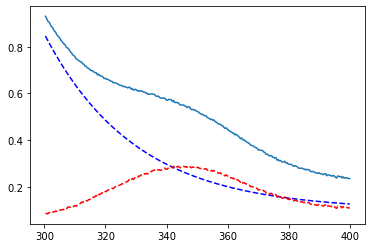

In [391]:
#get the x and y values for all the slope intervals we want 
x = 16

ydata = df[(df['wl']>=300) & (df['wl']<=400)][names[x]]
xdata = df[(df['wl']>=300) & (df['wl']<=400)]['wl']
ydata = np.asarray(ydata, dtype=float).ravel()
xdata = np.asarray(xdata, dtype=float).ravel()


#get the x and y values for all the slope intervals we want for the regression  
ydata_r1 = df[(df['wl']>=250) & (df['wl']<=300)][names[x]]
ydata_r2 = df[(df['wl']>=400) & (df['wl']<=700)][names[x]]
ydata_r = pd.concat([ydata_r1, ydata_r2], axis=0)

xdata_r1 = df[(df['wl']>=250) & (df['wl']<=300)]['wl']
xdata_r2 = df[(df['wl']>=400) & (df['wl']<=700)]['wl']
xdata_r = pd.concat([xdata_r1, xdata_r2], axis=0)

ydata_r = np.asarray(ydata_r, dtype=float).ravel()
xdata_r = np.asarray(xdata_r, dtype=float).ravel()

#set some innital guesses to the curve fit 
pams = (1, .001, 0)

#set the max evaluations
maxfev = 99999999

params, cv = curve_fit(exp_equation, xdata_r, ydata_r, p0=pams, maxfev = maxfev)
a, s, b = params

#set some innital guesses to the curve fit 
pams = (1, .001, 0)

#set the max evaluations
maxfev = 99999999

params, cv = curve_fit(exp_equation, xdata_r, ydata_r, p0=pams, maxfev = maxfev)
a, s, b = params

squaredDiffs = np.square(ydata_r - exp_equation(xdata_r, a, s, b))
squaredDiffsFromMean = np.square(ydata_r - np.mean(ydata_r))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
abs_254 = exp_equation(252, a, s, b)
print("for spectral slope 275 to 700")
print(f"abs 254 = {abs_254}")
print(f"R² = {rSquared}")
print(f"absorption coefficient = {a}")
print(f"offset = {b}")
print(f"Spectral Slope = {s}")
print(f"")

#uncomment this to look at the fit
fake_x = np.linspace(300, 400, num=274)
plt.plot(xdata, exp_equation(xdata, a, s, b), '--', color='blue', label="fitted")
diffs = ydata - exp_equation(xdata, a, s, b)
plt.plot(xdata, diffs, '--', color='red', label="fitted")
plt.plot(xdata,ydata)

xdata[273]

The offset of the gaussian baseline is 0.3934125552683711
The center of the gaussian fit is 346.49364856528183
The sigma of the gaussian fit is 20.094411510884107
The maximum intensity of the gaussian fit is 1.331464433752346
The Amplitude of the gaussian fit is 0.9380518784839749
The FWHM of the gaussian fit is 47.318722114060115
The R2 of the gaussian fit is 0.9843228947918101


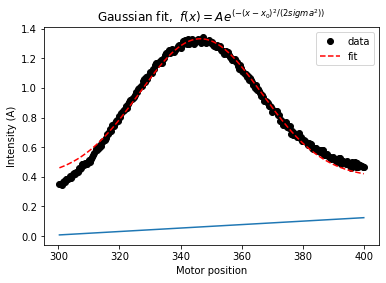

-0.3429271980461927

In [446]:
#here we normalize the data 
diffs = (diffs - np.min(diffs)) / (np.max(diffs) - np.min(diffs))
    
#here we make the data even along min and max
y1 = xdata[0]
y2 = xdata[273]
x1 = diffs[0]
x2 = diffs[273]
m = (x2 - x1)/(y2 - y1)
mx = m * y1
b = x1 - mx

diffs = diffs - ((m*diffs)+b)

H, A, x0, sigma = gauss_fit(xdata, diffs)
FWHM = 2.35482 * sigma

gaus_baseline = H
center_gaus = x0
sigma = sigma 
max_gaus = H + A
amp_gaus = A
FWHM = FWHM

print('The offset of the gaussian baseline is', gaus_baseline)
print('The center of the gaussian fit is', center_gaus)
print('The sigma of the gaussian fit is', sigma)
print('The maximum intensity of the gaussian fit is', H + A)
print('The Amplitude of the gaussian fit is', A)
print('The FWHM of the gaussian fit is', FWHM)

plt.plot(xdata, diffs, 'ko', label='data')
plt.plot(xdata, gauss(xdata, *gauss_fit(xdata, diffs)), '--r', label='fit')
plt.plot(xdata, ((m*xdata)+b))

squaredDiff = np.square(diffs - gauss(xdata, *gauss_fit(xdata, diffs)))
squaredDiffFromMean = np.square(diffs - np.mean(diffs))
rSqu = 1 - np.sum(squaredDiff) / np.sum(squaredDiffFromMean)
print('The R2 of the gaussian fit is', rSqu)

plt.legend()
plt.title('Gaussian fit,  $f(x) = A e^{(-(x-x_0)^2/(2sigma^2))}$')
plt.xlabel('Motor position')
plt.ylabel('Intensity (A)')
plt.show()
b

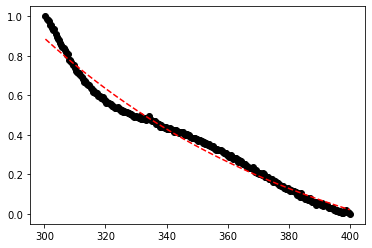

The offset of the gaussian baseline is -0.42734868369663087
The center of the gaussian fit is -17776.861742439887
The sigma of the gaussian fit is 1297.203154200521
The maximum intensity of the gaussian fit is 1.938992052717266e+42
The Amplitude of the gaussian fit is 1.938992052717266e+42
The FWHM of the gaussian fit is 3054.679931574471


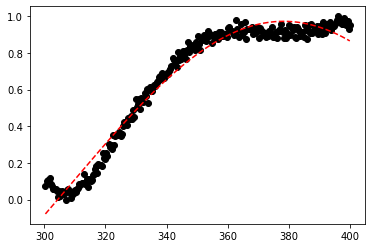

The offset of the gaussian baseline is -1.2638236130229634
The center of the gaussian fit is 378.2937456477144
The sigma of the gaussian fit is 69.1927167761321
The maximum intensity of the gaussian fit is 0.9723514263149893
The Amplitude of the gaussian fit is 2.2361750393379527
The FWHM of the gaussian fit is 162.9363933187714


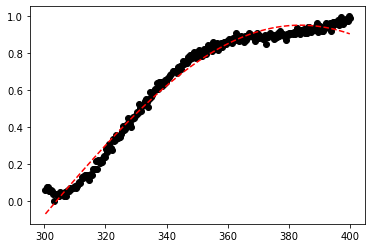

The offset of the gaussian baseline is -1.9394220104121627
The center of the gaussian fit is 383.7915155472181
The sigma of the gaussian fit is 89.28392864164616
The maximum intensity of the gaussian fit is 0.9516121912570865
The Amplitude of the gaussian fit is 2.891034201669249
The FWHM of the gaussian fit is 210.2475808439212


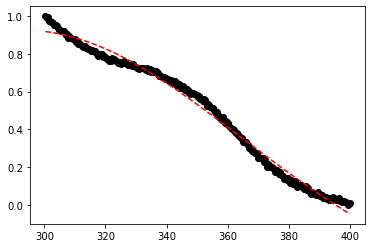

The offset of the gaussian baseline is -0.5174761213697596
The center of the gaussian fit is 293.12444979618255
The sigma of the gaussian fit is 71.22124391710476
The maximum intensity of the gaussian fit is 0.9262388490972291
The Amplitude of the gaussian fit is 1.4437149704669887
The FWHM of the gaussian fit is 167.71320960087664


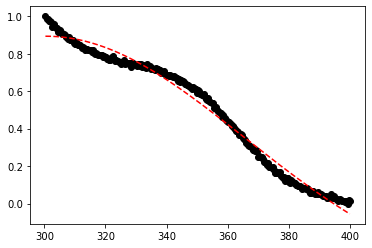

The offset of the gaussian baseline is -0.4809666270920084
The center of the gaussian fit is 300.5477594653137
The sigma of the gaussian fit is 64.9148938691676
The maximum intensity of the gaussian fit is 0.8933324826276512
The Amplitude of the gaussian fit is 1.3742991097196595
The FWHM of the gaussian fit is 152.86289038099326


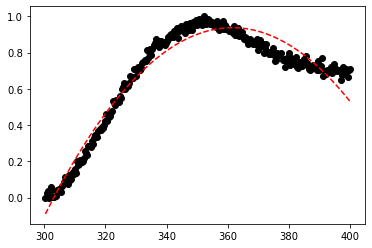

The offset of the gaussian baseline is -2582.6764185494817
The center of the gaussian fit is 361.5336697538706
The sigma of the gaussian fit is 2169.6878650458652
The maximum intensity of the gaussian fit is 0.9368416757251907
The Amplitude of the gaussian fit is 2583.613260225207
The FWHM of the gaussian fit is 5109.224378367305


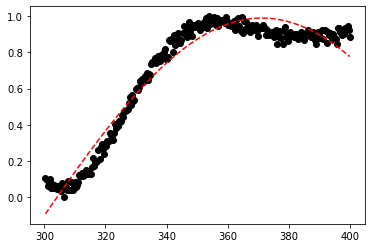

The offset of the gaussian baseline is -2.0799353662832796
The center of the gaussian fit is 371.1601423390658
The sigma of the gaussian fit is 75.89819675221896
The maximum intensity of the gaussian fit is 0.9900915865351738
The Amplitude of the gaussian fit is 3.0700269528184534
The FWHM of the gaussian fit is 178.72659167606028


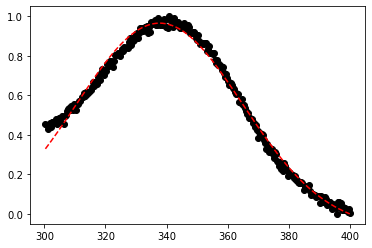

The offset of the gaussian baseline is -0.07629024467879947
The center of the gaussian fit is 337.7000870193497
The sigma of the gaussian fit is 27.190302986686362
The maximum intensity of the gaussian fit is 0.9650358174741418
The Amplitude of the gaussian fit is 1.0413260621529412
The FWHM of the gaussian fit is 64.02826927910878


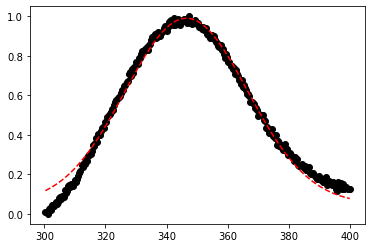

The offset of the gaussian baseline is 0.05054752796625714
The center of the gaussian fit is 346.49366132710736
The sigma of the gaussian fit is 20.094308557705652
The maximum intensity of the gaussian fit is 0.989694107056527
The Amplitude of the gaussian fit is 0.9391465790902699
The FWHM of the gaussian fit is 47.31847967785642


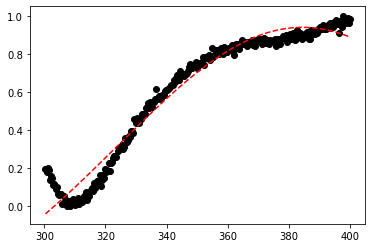

The offset of the gaussian baseline is -0.6461905657141732
The center of the gaussian fit is 384.48330026727683
The sigma of the gaussian fit is 60.609571525165244
The maximum intensity of the gaussian fit is 0.9417479640279515
The Amplitude of the gaussian fit is 1.5879385297421247
The FWHM of the gaussian fit is 142.72463121888964


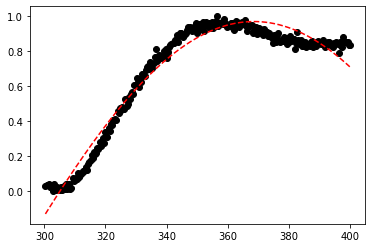

The offset of the gaussian baseline is -3.54053741324609
The center of the gaussian fit is 368.5851985473276
The sigma of the gaussian fit is 91.22282788901217
The maximum intensity of the gaussian fit is 0.9697536243351395
The Amplitude of the gaussian fit is 4.510291037581229
The FWHM of the gaussian fit is 214.81333956960364


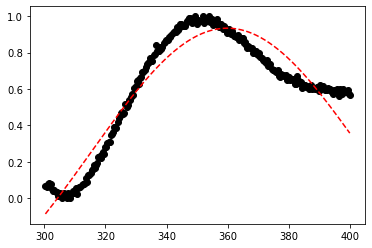

The offset of the gaussian baseline is -0.7891338134599805
The center of the gaussian fit is 359.84766907551654
The sigma of the gaussian fit is 44.44155536748309
The maximum intensity of the gaussian fit is 0.934415352993012
The Amplitude of the gaussian fit is 1.7235491664529925
The FWHM of the gaussian fit is 104.65186341045654


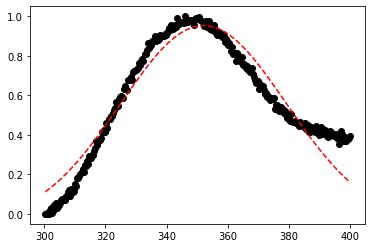

The offset of the gaussian baseline is -0.0509318240358195
The center of the gaussian fit is 352.09088347038204
The sigma of the gaussian fit is 27.134198533764717
The maximum intensity of the gaussian fit is 0.9524761402832164
The Amplitude of the gaussian fit is 1.003407964319036
The FWHM of the gaussian fit is 63.89615339127984


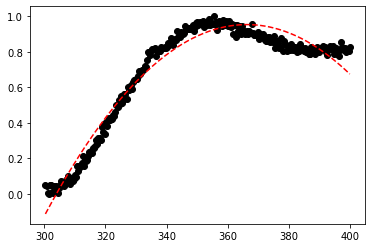

The offset of the gaussian baseline is -1444.9598040511687
The center of the gaussian fit is 366.26269895158606
The sigma of the gaussian fit is 1716.2535097235798
The maximum intensity of the gaussian fit is 0.9530888402377968
The Amplitude of the gaussian fit is 1445.9128928914065
The FWHM of the gaussian fit is 4041.46808976728


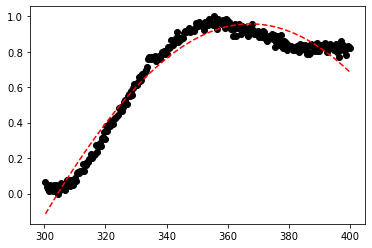

The offset of the gaussian baseline is -5.019209704156207
The center of the gaussian fit is 367.4304732151774
The sigma of the gaussian fit is 106.6972860301934
The maximum intensity of the gaussian fit is 0.9569159944334666
The Amplitude of the gaussian fit is 5.976125698589674
The FWHM of the gaussian fit is 251.25290308962002


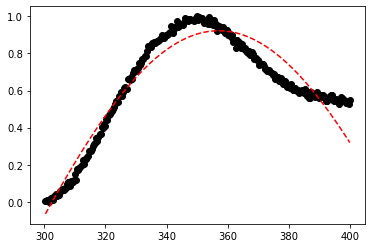

The offset of the gaussian baseline is -2.8569434907425437
The center of the gaussian fit is 357.02447733230963
The sigma of the gaussian fit is 72.8610818038395
The maximum intensity of the gaussian fit is 0.9219079281113043
The Amplitude of the gaussian fit is 3.778851418853848
The FWHM of the gaussian fit is 171.57473265331734


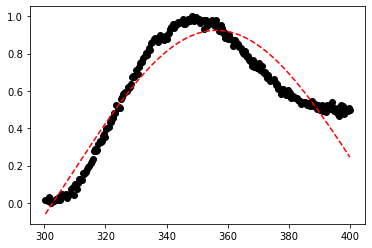

The offset of the gaussian baseline is -1.0245265297655108
The center of the gaussian fit is 356.2844044778214
The sigma of the gaussian fit is 47.208158549954426
The maximum intensity of the gaussian fit is 0.9243818605025014
The Amplitude of the gaussian fit is 1.9489083902680122
The FWHM of the gaussian fit is 111.16671591660369


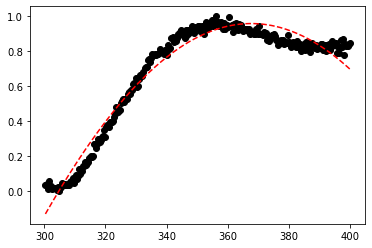

The offset of the gaussian baseline is -9.510785351538255
The center of the gaussian fit is 367.71173457291985
The sigma of the gaussian fit is 143.57751402429523
The maximum intensity of the gaussian fit is 0.9581238631789883
The Amplitude of the gaussian fit is 10.468909214717243
The FWHM of the gaussian fit is 338.0992015746909


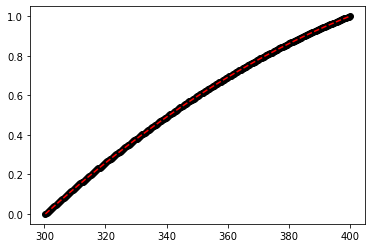

The offset of the gaussian baseline is -3578.5600083966015
The center of the gaussian fit is 479.47503033656045
The sigma of the gaussian fit is 6790.098907556567
The maximum intensity of the gaussian fit is 1.2455099994981538
The Amplitude of the gaussian fit is 3579.8055183960996
The FWHM of the gaussian fit is 15989.460709492356


In [388]:
#HERE WE FIND THE INTIGRAL OF ALL THE SAMPLE FOR 350 INFLECTION 
Frames = []
maxfev = 10000000
for (columnName, columnData) in df.iteritems():
    col = columnName
    #define where we expect to find the inflection 
    ydata = df[(df['wl']>=300) & (df['wl']<=400)][col]
    xdata = df[(df['wl']>=300) & (df['wl']<=400)]['wl']
    ydata = np.asarray(ydata, dtype=float).ravel()
    xdata = np.asarray(xdata, dtype=float).ravel()
    
    #here we take evething not in the infelction for the abs data
    ydata_r1 = df[(df['wl']>=250) & (df['wl']<=300)][col]
    ydata_r2 = df[(df['wl']>=400) & (df['wl']<=700)][col]
    ydata_r = pd.concat([ydata_r1, ydata_r2], axis=0)
    
    #here we take evething not in the infelction for the wl data
    xdata_r1 = df[(df['wl']>=250) & (df['wl']<=300)]['wl']
    xdata_r2 = df[(df['wl']>=400) & (df['wl']<=700)]['wl']
    xdata_r = pd.concat([xdata_r1, xdata_r2], axis=0)
    
    #here we make them both arrays so we can doo math 
    ydata_r = np.asarray(ydata_r, dtype=float).ravel()
    xdata_r = np.asarray(xdata_r, dtype=float).ravel()
    
    #set some innital guesses to the curve fit 
    pams = (1, .001, 0)
    
    #here we do an expodental fit for just the data where we expect there to de no inflection 
    #aka, what the regression would be without the inflection 
    params, cv = curve_fit(exp_equation, xdata_r, ydata_r, p0=pams, maxfev = maxfev)
    a, s, b = params
    
    #here we calculate the R squared of that regressions fit 
    squaredDiffs = np.square(ydata_r - exp_equation(xdata_r, a, s, b))
    squaredDiffsFromMean = np.square(ydata_r - np.mean(ydata_r))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    
    #here we take the differance of the accual data and the regressions fit that dident have that data 
    diffs = ydata - exp_equation(xdata, a, s, b)
    
    #here we normalize the data 
    diffs = (diffs - np.min(diffs)) / (np.max(diffs) - np.min(diffs))
    
    
    #here we calculate the intigral 
    inter = scipy.integrate.simps(ydata, x=diffs, even='avg')
    
    #here we do a gausian regression 
    H, A, x0, sigma = gauss_fit(xdata, diffs)
    FWHM = 2.35482 * sigma

    gaus_baseline = H
    center_gaus = x0
    sigma = sigma 
    max_gaus = H + A
    amp_gaus = A
    FWHM = FWHM
    
    plt.plot(xdata, diffs, 'ko', label='data')
    plt.plot(xdata, gauss(xdata, *gauss_fit(xdata, diffs)), '--r', label='fit')
    plt.show()
    print('The offset of the gaussian baseline is', gaus_baseline)
    print('The center of the gaussian fit is', center_gaus)
    print('The sigma of the gaussian fit is', sigma)
    print('The maximum intensity of the gaussian fit is', H + A)
    print('The Amplitude of the gaussian fit is', A)
    print('The FWHM of the gaussian fit is', FWHM)
    
    

plt.show()

IndexError: index 6 is out of bounds for axis 0 with size 5

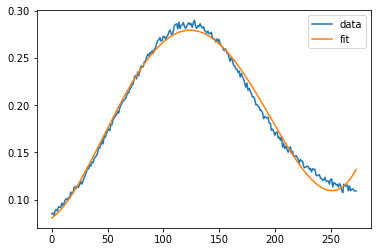

In [274]:
poly = np.polyfit(xdata, diffs, deg=4)
poly

fig, ax = plt.subplots()
ax.plot(diffs, label='data')
ax.plot(np.polyval(poly, xdata), label='fit')
ax.legend()

poly[6]

In [193]:
#HERE WE TEST TO MAKE SURE THE R SQAURED IS GOOD 
#this will let us know if something is wrong and where 

diffs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
diffs = diffs.drop('wl') # drops the wl col 

R_level = .95 #set x to the r2 value you want to test

min_1 = diffs['R2'].min()
min_2 = diffs['R2_gaus'].min()

if min_1 < R_level: 
    print("!!! WARNING !!! 275_700 has a bad R2 !!!")
else: 
    print("THE FITS ARE GOOD, YAY!")

diffs.loc[diffs.R2 < R_level, '350_intergration'] = np.nan

#diffs.loc[diffs.sigma < 0, 'center_gaus'] = np.nan
#diffs.loc[diffs.sigma < 0, 'max_gaus'] = np.nan
#diffs.loc[diffs.sigma < 0, 'amp_gaus'] = np.nan

#diffs.loc[diffs.sigma > 1000, 'center_gaus'] = np.nan
#diffs.loc[diffs.sigma > 1000, 'max_gaus'] = np.nan
#diffs.loc[diffs.sigma > 1000, 'amp_gaus'] = np.nan

#diffs.loc[diffs.center_gaus < 300, 'center_gaus'] = np.nan
#diffs.loc[diffs.center_gaus < 300, 'max_gaus'] = np.nan
#diffs.loc[diffs.center_gaus < 300, 'amp_gaus'] = np.nan

#diffs.loc[diffs.center_gaus > 400, 'center_gaus'] = np.nan
#diffs.loc[diffs.center_gaus > 400, 'max_gaus'] = np.nan
#diffs.loc[diffs.center_gaus > 400, 'amp_gaus'] = np.nan

#diffs.loc[diffs.max_gaus < 0, 'center_gaus'] = np.nan
#diffs.loc[diffs.max_gaus < 0, 'max_gaus'] = np.nan
#diffs.loc[diffs.max_gaus < 0, 'amp_gaus'] = np.nan

#diffs.loc[diffs.amp_gaus < 0, 'center_gaus'] = np.nan
#diffs.loc[diffs.amp_gaus < 0, 'max_gaus'] = np.nan
#diffs.loc[diffs.amp_gaus < 0, 'amp_gaus'] = np.nan

#diffs.loc[diffs.FWHM < 0, 'center_gaus'] = np.nan
#diffs.loc[diffs.FWHM < 0, 'max_gaus'] = np.nan
#diffs.loc[diffs.FWHM < 0, 'amp_gaus'] = np.nan

#diffs.loc[diffs.FWHM > 1000, 'center_gaus'] = np.nan
#diffs.loc[diffs.FWHM > 1000, 'max_gaus'] = np.nan
#diffs.loc[diffs.FWHM > 1000, 'amp_gaus'] = np.nan

diffs

THE FITS ARE GOOD, YAY!
THE FITS ARE GOOD, YAY!


,gaus_baseline,center_gaus,sigma,max_gaus,amp_gaus,FWHM,350_intergration,R2,R2_gaus
sample,,,,,,,,,
222601,-0.130354,-17807.494102,1298.304209,7.632141e+41,7.632141e+41,3057.272718,-0.063279,0.977326,0.978584
222602,-0.033423,306.127883,20.191278,-1.378255e-01,-1.044025e-01,47.546826,0.016062,0.990311,0.994430
222603,0.003315,300.962434,-25.212144,-1.625097e-01,-1.658247e-01,-59.370060,0.073726,0.990867,0.995812
222604,-0.133406,293.124347,71.221478,4.634058e-01,5.968121e-01,167.713760,-0.210819,0.974642,0.988838
222605,-0.142152,300.547621,64.915286,3.923130e-01,5.344655e-01,152.863813,-0.136213,0.975996,0.984094
222606,-369.880808,NaN,2218.356379,NaN,NaN,5223.829969,0.051192,0.996613,0.947731
222607,-0.007658,307.073632,16.327322,-9.324935e-02,-8.559111e-02,38.447905,0.014348,0.997915,0.988831
222608,0.045811,337.700077,27.190270,2.134065e-01,1.675955e-01,64.028191,0.006853,0.985835,0.989491
222609,0.093820,346.493652,20.094405,2.878246e-01,1.940041e-01,47.318708,0.070517,0.989789,0.984323


In [51]:
#HERE WE FIND THE INTIGRAL OF ALL THE SAMPLE FOR 350 INFLECTION 
Frames = []
maxfev = 10000000
for (columnName, columnData) in df.iteritems():
    col = columnName
    #define where we expect to find the inflection 
    ydata = df[(df['wl']>=300) & (df['wl']<=400)][col]
    xdata = df[(df['wl']>=300) & (df['wl']<=400)]['wl']
    ydata = np.asarray(ydata, dtype=float).ravel()
    xdata = np.asarray(xdata, dtype=float).ravel()
    
    #here we take evething not in the infelction for the abs data
    ydata_r1 = df[(df['wl']>=250) & (df['wl']<=300)][col]
    ydata_r2 = df[(df['wl']>=400) & (df['wl']<=700)][col]
    ydata_r = pd.concat([ydata_r1, ydata_r2], axis=0)
    
    #here we take evething not in the infelction for the wl data
    xdata_r1 = df[(df['wl']>=250) & (df['wl']<=300)]['wl']
    xdata_r2 = df[(df['wl']>=400) & (df['wl']<=700)]['wl']
    xdata_r = pd.concat([xdata_r1, xdata_r2], axis=0)
    
    #here we make them both arrays so we can doo math 
    ydata_r = np.asarray(ydata_r, dtype=float).ravel()
    xdata_r = np.asarray(xdata_r, dtype=float).ravel()
    
    #set some innital guesses to the curve fit 
    pams = (1, .001, 0)
    
    #set the max evaluations
    maxfev = 99999999
    
    #here we do an expodental fit for just the data where we expect there to de no inflection 
    #aka, what the regression would be without the inflection 
    params, cv = curve_fit(exp_equation, xdata_r, ydata_r, p0=pams, maxfev = maxfev)
    a, s, b = params
    
    #here we calculate the R squared of that regressions fit 
    squaredDiffs = np.square(ydata_r - exp_equation(xdata_r, a, s, b))
    squaredDiffsFromMean = np.square(ydata_r - np.mean(ydata_r))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    
    #here we take the differance of the accual data and the regressions fit that dident have that data 
    diffs = ydata - exp_equation(xdata, a, s, b)
    
    #here we calculate the intigral 
    inter = scipy.integrate.simps(ydata, x=diffs, even='avg')
    
    #here we define some columns for a new data frame with the sample, the R2, and the diffs intigral 
    dict = {'sample':[columnName],
        'inter_350':[inter],
        'R2':[rSquared]}
    diff = pd.DataFrame(dict)
    
    #here we set the index and append the data together 
    diffs = diff.set_index('sample', drop=True)
    Frames.append(diffs) # adds the new col from each scan to a part of frames 
    
diffs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
diffs = diffs.drop('wl') # drops the wl col 
diffs

,inter_350,R2
sample,,
222601,-0.063279,0.977326
222602,0.016062,0.990311
222603,0.073726,0.990867
222604,-0.210819,0.974642
222605,-0.136213,0.975996
222606,0.051192,0.996613
222607,0.014348,0.997915
222608,0.006853,0.985835
222609,0.070517,0.989789


In [30]:
#HERE WE TEST TO MAKE SURE THE R SQAURED IS GOOD 
#this will let us know if something is wrong and where 

diffs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
diffs = diffs.drop('wl') # drops the wl col 

R_level = .95 #set x to the r2 value you want to test

min_1 = diffs['R2'].min()

if min_1 < R_level: 
    print("!!! WARNING !!! 275_700 has a bad R2 !!!")
else: 
    print("THE FITS ARE GOOD, YAY!")

diffs.loc[diffs.R2 < R_level, '350_intergration'] = np.nan

diffs

THE FITS ARE GOOD, YAY!


,350_intergration,R2
sample,,
222601,-0.063279,0.977326
222602,0.016062,0.990311
222603,0.073726,0.990867
222604,-0.210819,0.974642
222605,-0.136213,0.975996
222606,0.051192,0.996613
222607,0.014348,0.997915
222608,0.006853,0.985835
222609,0.070517,0.989789


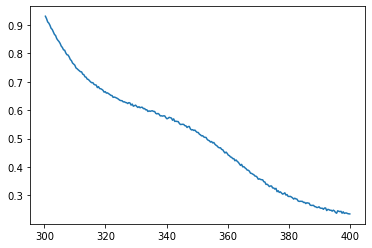

In [318]:
#get the x and y values for all the slope intervals we want 
ydata = df[(df['wl']>=300) & (df['wl']<=400)][names[16]]
xdata = df[(df['wl']>=300) & (df['wl']<=400)]['wl']
ydata = np.asarray(ydata, dtype=float).ravel()
xdata = np.asarray(xdata, dtype=float).ravel()

plt.plot(xdata,ydata)

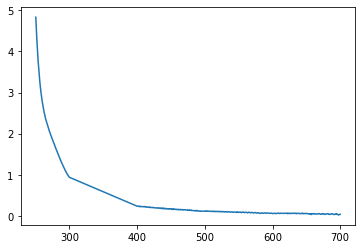

In [319]:
#get the x and y values for all the slope intervals we want for the regression  
ydata_r1 = df[(df['wl']>=250) & (df['wl']<=300)][names[16]]
ydata_r2 = df[(df['wl']>=400) & (df['wl']<=700)][names[16]]
ydata_r = pd.concat([ydata_r1, ydata_r2], axis=0)

xdata_r1 = df[(df['wl']>=250) & (df['wl']<=300)]['wl']
xdata_r2 = df[(df['wl']>=400) & (df['wl']<=700)]['wl']
xdata_r = pd.concat([xdata_r1, xdata_r2], axis=0)

ydata_r = np.asarray(ydata_r, dtype=float).ravel()
xdata_r = np.asarray(xdata_r, dtype=float).ravel()

plt.plot(xdata_r,ydata_r)

for spectral slope 275 to 700
abs 254 = 3.8950188479743297
R² = 0.9897890833305368
absorption coefficient = 18309.706143438176
offset = 0.09989848344784216
Spectral Slope = 0.03365662881595903



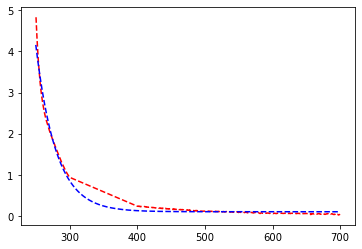

In [320]:
#set some innital guesses to the curve fit 
pams = (1, .001, 0)

#set the max evaluations
maxfev = 99999999

params, cv = curve_fit(exp_equation, xdata_r, ydata_r, p0=pams, maxfev = maxfev)
a, s, b = params

squaredDiffs = np.square(ydata_r - exp_equation(xdata_r, a, s, b))
squaredDiffsFromMean = np.square(ydata_r - np.mean(ydata_r))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
abs_254 = exp_equation(252, a, s, b)
print("for spectral slope 275 to 700")
print(f"abs 254 = {abs_254}")
print(f"R² = {rSquared}")
print(f"absorption coefficient = {a}")
print(f"offset = {b}")
print(f"Spectral Slope = {s}")
print(f"")


#uncomment this to look at the fit
fake_x = np.linspace(250, 700, num=1017)
plt.plot(xdata_r, ydata_r, '--', color='red', label="data")
plt.plot(fake_x, exp_equation(fake_x, a, s, b), '--', color='blue', label="fitted")



for spectral slope 275 to 700
abs 254 = 3.8950188479743297
R² = 0.9897890833305368
absorption coefficient = 18309.706143438176
offset = 0.09989848344784216
Spectral Slope = 0.03365662881595903



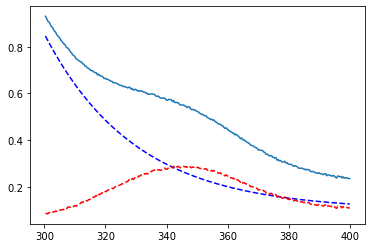

In [321]:
#set some innital guesses to the curve fit 
pams = (1, .001, 0)

#set the max evaluations
maxfev = 99999999

params, cv = curve_fit(exp_equation, xdata_r, ydata_r, p0=pams, maxfev = maxfev)
a, s, b = params

squaredDiffs = np.square(ydata_r - exp_equation(xdata_r, a, s, b))
squaredDiffsFromMean = np.square(ydata_r - np.mean(ydata_r))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
abs_254 = exp_equation(252, a, s, b)
print("for spectral slope 275 to 700")
print(f"abs 254 = {abs_254}")
print(f"R² = {rSquared}")
print(f"absorption coefficient = {a}")
print(f"offset = {b}")
print(f"Spectral Slope = {s}")
print(f"")

#uncomment this to look at the fit
fake_x = np.linspace(300, 400, num=274)
plt.plot(xdata, exp_equation(xdata, a, s, b), '--', color='blue', label="fitted")
diffs = ydata - exp_equation(xdata, a, s, b)
plt.plot(xdata, diffs, '--', color='red', label="fitted")
plt.plot(xdata,ydata)


The offset of the gaussian baseline is -0.007658237925526454
The center of the gaussian fit is 307.07363172247267
The sigma of the gaussian fit is 16.32732218770835
The maximum intensity of the gaussian fit is -0.09324934859268129
The Amplitude of the gaussian fit is -0.08559111066715483
The FWHM of the gaussian fit is 38.44790483405938
The R2 of the gaussian fit is 0.9888309038006602


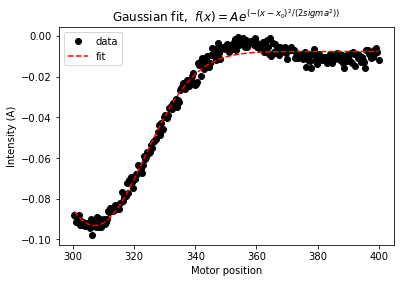

In [190]:
H, A, x0, sigma = gauss_fit(xdata, diffs)
FWHM = 2.35482 * sigma

print('The offset of the gaussian baseline is', H)
print('The center of the gaussian fit is', x0)
print('The sigma of the gaussian fit is', sigma)
print('The maximum intensity of the gaussian fit is', H + A)
print('The Amplitude of the gaussian fit is', A)
print('The FWHM of the gaussian fit is', FWHM)

plt.plot(xdata, diffs, 'ko', label='data')
plt.plot(xdata, gauss(xdata, *gauss_fit(xdata, diffs)), '--r', label='fit')

squaredDiff = np.square(diffs - gauss(xdata, *gauss_fit(xdata, diffs)))
squaredDiffFromMean = np.square(diffs - np.mean(diffs))
rSqu = 1 - np.sum(squaredDiff) / np.sum(squaredDiffFromMean)
print('The R2 of the gaussian fit is', rSqu)

plt.legend()
plt.title('Gaussian fit,  $f(x) = A e^{(-(x-x_0)^2/(2sigma^2))}$')
plt.xlabel('Motor position')
plt.ylabel('Intensity (A)')
plt.show()

The offset of the gaussian baseline is -0.1334063322252521
The center of the gaussian fit is 293.12434720890656
The sigma of the gaussian fit is 71.22147753766998
The maximum intensity of the gaussian fit is 0.4634057802552075
The Amplitude of the gaussian fit is 0.5968121124804596
The FWHM of the gaussian fit is 167.71375973525605


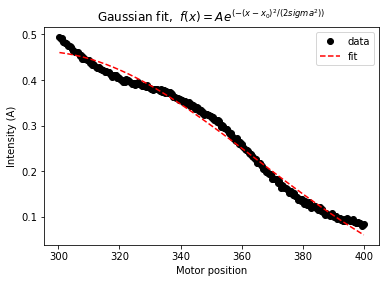

In [151]:
H, A, x0, sigma = gauss_fit(xdata, diffs)
FWHM = 2.35482 * sigma

print('The offset of the gaussian baseline is', H)
print('The center of the gaussian fit is', x0)
print('The sigma of the gaussian fit is', sigma)
print('The maximum intensity of the gaussian fit is', H + A)
print('The Amplitude of the gaussian fit is', A)
print('The FWHM of the gaussian fit is', FWHM)

plt.plot(xdata, diffs, 'ko', label='data')
plt.plot(xdata, gauss(xdata, *gauss_fit(xdata, diffs)), '--r', label='fit')

plt.legend()
plt.title('Gaussian fit,  $f(x) = A e^{(-(x-x_0)^2/(2sigma^2))}$')
plt.xlabel('Motor position')
plt.ylabel('Intensity (A)')
plt.show()

The offset of the gaussian baseline is 0.09382044932954081
The center of the gaussian fit is 346.4936517111357
The sigma of the gaussian fit is 20.094405451932523
The maximum intensity of the gaussian fit is 0.28782455277873376
The Amplitude of the gaussian fit is 0.19400410344919294
The width at half maximum of the gaussian fit is 47.31870784631975


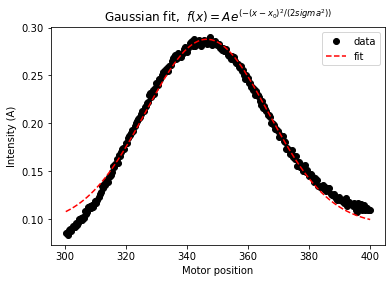

In [40]:
# generate simulated data
H, A, x0, sigma = gauss_fit(xdata, diffs)
FWHM = 2.35482 * sigma

print('The offset of the gaussian baseline is', H)
print('The center of the gaussian fit is', x0)
print('The sigma of the gaussian fit is', sigma)
print('The maximum intensity of the gaussian fit is', H + A)
print('The Amplitude of the gaussian fit is', A)
print('The width at half maximum of the gaussian fit is', FWHM)

plt.plot(xdata, diffs, 'ko', label='data')
plt.plot(xdata, gauss(xdata, *gauss_fit(xdata, diffs)), '--r', label='fit')

plt.legend()
plt.title('Gaussian fit,  $f(x) = A e^{(-(x-x_0)^2/(2sigma^2))}$')
plt.xlabel('Motor position')
plt.ylabel('Intensity (A)')
plt.show()

In [35]:
scipy.integrate.simps(ydata, x=diffs, even='avg')

0.07051735210686964

,222601,222602,222603,222604,222605,222606,222607,222608,222609,222610,222611,222612,222613,222614,222615,222616,222617,222618,wl
wl,,,,,,,,,,,,,,,,,,,
189.2794,-0.314775,0.000000,0.000000,-4.074139,-5.726825,-6.655104,0.000000,0.000000,0.000000,-0.515029,0.000000,0.000000,-0.376440,-0.070868,0.000000,2.356249,-1.048935,-2.759982,189.2794
189.6618,-0.314775,0.000000,0.000000,-4.074139,-5.726825,-6.655104,0.000000,0.000000,0.000000,-0.515029,0.000000,0.000000,-0.376440,-0.070868,0.000000,2.356249,-1.048935,-2.759982,189.6618
190.0441,-0.314775,0.000000,0.000000,-4.074139,-5.726825,-6.655104,0.000000,0.000000,0.000000,-0.515029,0.000000,0.000000,-0.376440,-0.070868,0.000000,2.356249,-1.048935,-2.759982,190.0441
190.4264,-2.412959,0.000000,0.000000,0.000000,0.000000,0.000000,-1.994124,0.000000,0.000000,0.524625,0.000000,0.792521,0.000000,1.284819,-0.292752,0.000000,-1.725520,0.000000,190.4264
190.8087,-0.865277,0.000000,0.000000,0.000000,-5.260562,-6.486154,-0.172961,0.000000,0.000000,-2.281921,-1.262560,-4.727128,0.000000,0.741553,0.031147,1.357260,-1.442207,-1.849322,190.8087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880.5978,0.383440,-0.124117,1.067497,0.315247,0.583301,1.567267,0.141696,0.367631,1.064036,0.305336,0.320753,0.449431,0.423003,0.326652,0.318708,0.536737,0.009439,0.344978,880.5978
880.8884,0.184051,0.271358,1.049564,0.617751,1.164714,1.752734,-0.145471,0.151331,0.700968,0.456353,0.248548,0.588020,0.296370,0.341203,0.382260,0.632774,0.333966,0.289605,880.8884
881.1790,0.260503,0.249649,1.233143,0.506377,0.956123,2.118005,0.150309,0.496938,1.200738,0.549794,0.459971,0.616178,0.371878,0.278358,0.344034,0.555850,-0.155578,0.143623,881.1790


Line Solution is y = -0.006980673043905974x + 3.0272389970198406


C:\Users\12532\AppData\Local\Temp\ipykernel_25140\1723926130.py:12: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = lstsq(A, y_coords)[0]


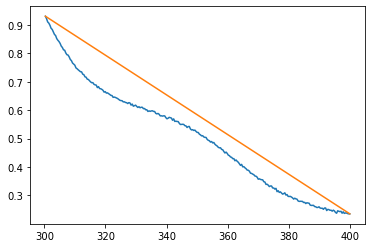

In [366]:
from numpy import ones,vstack
from numpy.linalg import lstsq

y1 = df[(df['wl']>=300) & (df['wl']<=300.5)][names[16]].mean()
y2 = df[(df['wl']>=400) & (df['wl']<=400.5)][names[16]].mean()
x1 = df[(df['wl']>=300) & (df['wl']<=300.5)]['wl'].mean()
x2 = df[(df['wl']>=400) & (df['wl']<=400.5)]['wl'].mean()

points = [(x1,y1),(x2,y2)]
x_coords, y_coords = zip(*points)
A = vstack([x_coords,ones(len(x_coords))]).T
m, c = lstsq(A, y_coords)[0]
print("Line Solution is y = {m}x + {c}".format(m=m,c=c))

plt.plot(xdata,ydata)
plt.plot(xdata, (m*xdata)+c)

4.203876021796124

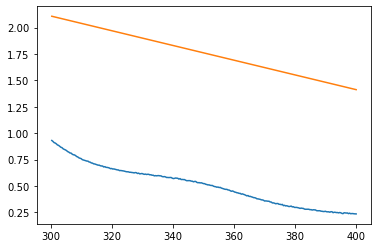

In [365]:
from sklearn.linear_model import LinearRegression
y1 = df[(df['wl']>=300) & (df['wl']<=300.5)][names[16]].mean()
y2 = df[(df['wl']>=400) & (df['wl']<=400.5)][names[16]].mean()
x1 = df[(df['wl']>=300) & (df['wl']<=300.5)]['wl'].mean()
x2 = df[(df['wl']>=400) & (df['wl']<=400.5)]['wl'].mean()

slope = (y2 - y1)/(x2 - x1)
x = (x2 + x1)/2
y = (y2 + y1)/2
b = - slope * x / y 
b

#ydata_r = pd.concat([y1, y2], axis=0)
#xdata_r = pd.concat([x1, x2], axis=0)
#ydata_r = np.asarray(ydata_r, dtype=float).ravel()
#xdata_r = np.asarray(xdata_r, dtype=float).ravel()
#xdata_r

#model = LinearRegression().fit(xdata_r, ydata_r)

plt.plot(xdata,ydata)
plt.plot(xdata, (slope*xdata)+b)
b

In [30]:
scipy.signal.find_peaks(ydata)

(array([ 42,  47,  53,  55,  61,  70,  74,  77,  80,  83,  85,  88,  90,
         92,  95, 100, 103, 105, 110, 114, 116, 122, 128, 131, 133, 140,
        148, 150, 156, 161, 168, 170, 175, 177, 191, 198, 201, 206, 208,
        210, 214, 216, 219, 223, 228, 232, 234, 240, 245, 248, 250, 253,
        256, 258, 262, 265, 267, 269], dtype=int64),
 {})

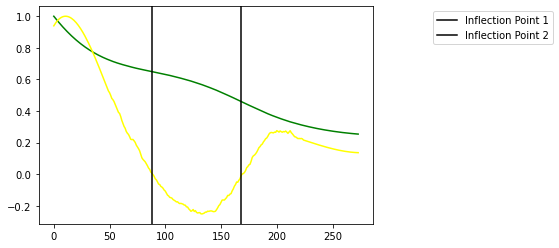

In [31]:
# smoothing with savgol_filter
smooth = savgol_filter(ydata, 99, 5)
d1 = savgol_filter(ydata, 99, 5, 1)
d2 = savgol_filter(ydata, 99, 5, 2)

#plt.plot(xdata,ydata)
#plt.plot(xdata,smooth, color='green')
#plt.plot(xdata,d1, color='red')
#plt.plot(xdata,d2, color='yellow')

#plt.plot(ydata/np.max(ydata), color='blue')
plt.plot(smooth/np.max(smooth), color='green')
#plt.plot(d1/np.max(d1), color='red')
plt.plot(d2/np.max(d2), color='yellow')

infls = np.where(np.diff(np.sign(d2)))[0]

for i, infl in enumerate(infls, 1):
    plt.axvline(x=infl, color='k', label=f'Inflection Point {i}')
plt.legend(bbox_to_anchor=(1.55, 1.0))


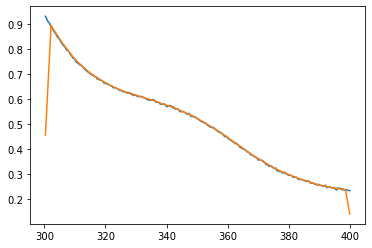

In [32]:
#smoothing with np.convolve
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

plt.plot(xdata, ydata)
plt.plot(xdata, smooth(ydata,10))


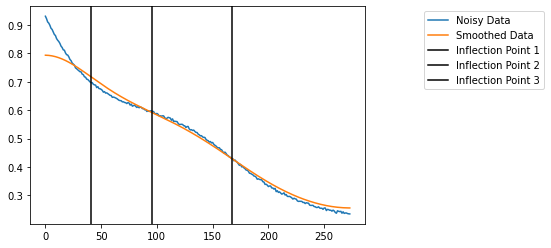

In [33]:
# smoothing with gaussian_filter1d
std = np.std(xdata)
smooth = gaussian_filter1d(ydata, std)

# compute second derivative
smooth_d1 = np.gradient(smooth)
smooth_d2 = np.gradient(np.gradient(smooth))

# find switching points
infls = np.where(np.diff(np.sign(smooth_d2)))[0]

# plot results
plt.plot(ydata, label='Noisy Data')
plt.plot(smooth, label='Smoothed Data')
#plt.plot(smooth_d1 / np.max(smooth_d1), label='First Derivative (scaled)')
#plt.plot(smooth_d2 / np.max(smooth_d2), label='Second Derivative (scaled)')
for i, infl in enumerate(infls, 1):
    plt.axvline(x=infl, color='k', label=f'Inflection Point {i}')
plt.legend(bbox_to_anchor=(1.55, 1.0))

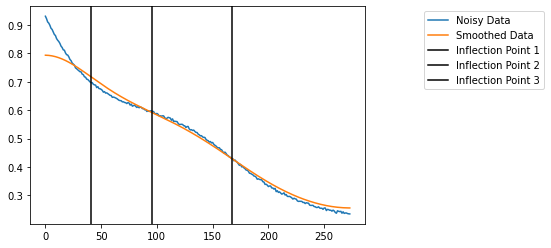

In [34]:
plt.plot(ydata, label='Noisy Data')
plt.plot(smooth, label='Smoothed Data')
for i, infl in enumerate(infls, 1):
    plt.axvline(x=infl, color='k', label=f'Inflection Point {i}')
plt.legend(bbox_to_anchor=(1.55, 1.0))

In [35]:
2qnxutqahu 9xh9phaxrh up
xqrji0

SyntaxError: invalid decimal literal (2222134103.py, line 1)

In [ ]:
#HERE DO THE WHOLE EXPO AS A LOOP FOR ALL SAMPLES 
Frames = []
maxfev = 10000000
for (columnName, columnData) in df.iteritems():
    col = columnName
    #get the x and y values for all the slope intervals we want 
    ydata_s700 = df[(df['wl']>=275) & (df['wl']<=700)][col]
    xdata_s700 = df[(df['wl']>=275) & (df['wl']<=700)]['wl']
    ydata_s700 = np.asarray(ydata_s700, dtype=float).ravel()
    xdata_s700 = np.asarray(xdata_s700, dtype=float).ravel()
    
    #set some innital guesses to the curve fit 
    pams_700 = (15, .001, 0)

    #regression exp_equation 275 to 700
    params, cv = curve_fit(exp_equation, xdata_s700, ydata_s700, p0=pams_700, maxfev=maxfev)
    a, s, b = params
    
    #get the valuse for exp_equation 275 to 700 and calcuate rSquared
    Diffs = ydata_s700 - exp_equation(xdata_s700, a, s, b)

    Diffs = pd.DataFrame(Diffs)
    Frames.append(Diffs) # adds the new col from each scan to a part of frames 
    
Diffs = pd.concat(Frames, axis=1) # adds all the things in the frame together to make a new df 
Diffs = pd.DataFrame(data=Diffs.values, columns=df.columns)
xdata_s700 = df[(df['wl']>=275) & (df['wl']<=700)]['wl']
dif = Diffs.set_index(xdata_s700)
dif['wl'] = dif.index
dif

In [ ]:
df = dif

#get the x and y values for all the slope intervals we want 
ydata = df[(df['wl']>=300) & (df['wl']<=400)][names[9]]
xdata = df[(df['wl']>=300) & (df['wl']<=400)]['wl']
ydata = np.asarray(ydata, dtype=float).ravel()
xdata = np.asarray(xdata, dtype=float).ravel()

#plt.plot(xdata,ydata)

# smoothing with gaussian_filter1d
std = np.std(xdata)
smooth = gaussian_filter1d(ydata, std)

# compute second derivative
smooth_d1 = np.gradient(smooth)
smooth_d2 = np.gradient(np.gradient(smooth))

# find switching points
infls = np.where(np.diff(np.sign(smooth_d1)))[0]

# plot results
plt.plot(ydata/ np.max(ydata), label='Noisy Data')
plt.plot(smooth/ np.max(smooth), label='Smoothed Data')
plt.plot(smooth_d1 / np.max(smooth_d1), label='First Derivative (scaled)')
plt.plot(smooth_d2 / np.max(smooth_d2), label='Second Derivative (scaled)')
for i, infl in enumerate(infls, 1):
    plt.axvline(x=infl, color='k', label=f'Inflection Point {i}')
plt.legend(bbox_to_anchor=(1.55, 1.0))

In [ ]:
# smoothing with savgol_filter

ydata = df[(df['wl']>=300) & (df['wl']<=400)][names[3]]
xdata = df[(df['wl']>=300) & (df['wl']<=400)]['wl']
ydata = np.asarray(ydata, dtype=float).ravel()
xdata = np.asarray(xdata, dtype=float).ravel()

smooth = savgol_filter(ydata, 99, 3)
d1 = savgol_filter(ydata, 99, 3, 1)
d2 = savgol_filter(ydata, 99, 3, 2)

#plt.plot(xdata,ydata)
#plt.plot(xdata,smooth, color='green')
#plt.plot(xdata,d1, color='red')
#plt.plot(xdata,d2, color='yellow')

plt.plot(ydata/np.max(ydata), color='blue')
plt.plot(smooth/np.max(smooth), color='green')
plt.plot(d1/np.max(d1), color='red')
plt.plot(d2/np.max(d2), color='yellow')

infls = np.where(np.diff(np.sign(d1)))[0]

for i, infl in enumerate(infls, 1):
    plt.axvline(x=infl, color='k', label=f'Inflection Point {i}')
plt.legend(bbox_to_anchor=(1.55, 1.0))


In [ ]:
def Gauss(x, A, B):
    y = A*np.exp(-1*B*x**2)
    return y
parameters, covariance = curve_fit(Gauss, xdata, ydata)
  
fit_A = parameters[0]
fit_B = parameters[1]
  
fit_y = Gauss(xdata, fit_A, fit_B)
plt.plot(xdata, ydata, 'o', label='data')
plt.plot(xdata, fit_y, '-', label='fit')
plt.legend()